## Make


In [1]:
!pip install pandas-highcharts

In [2]:
import os
import datetime

import IPython
import IPython.display
import requests
import json
import time
import math
import re
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
import seaborn as sns
 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
 
from sklearn import set_config
# set_config(display='diagram') # Để trực quan hóa pipeline
 
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.utils import resample

from pandas_highcharts.display import display_charts
from pandas_highcharts.display import load_highcharts
from pandas_highcharts.core import serialize
from IPython.core.display import display, HTML
from pandas_highcharts.core import json_encode

In [3]:
#Set Option
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_theme()

## Đề Tài

Nhóm muốn nghiên cứu, tìm hiểu các thông tin thú vị về thực phẩm Việt Nam. Đây là vấn đề về **khoa học thực phẩm**, gắn chặt với đời sống hàng ngày của chúng ta, ảnh hưởng trực tiếp đến sức khỏe, và đặc biệt là trong thời kỳ dịch bệnh, ta đã để tâm hơn đến sức khỏe, và có nhiều thời gian hơn để quan tâm đến bữa ăn

## Dữ liệu

Dữ liệu được lấy từ sách "Bảng Thành Phần Dinh Dưỡng Việt Nam", cung cấp bởi Bộ Y Tế - Viện Dinh Dưỡng

Ebook: https://drive.google.com/file/d/0B4RM9E8In1vFX1RYcEFDQ1VwZ1k/view (provided by Ministry of Health of Vietnam - http://chuyentrang.viendinhduong.vn/)

Xls: https://drive.google.com/file/d/0B4RM9E8In1vFS2VVaFBLLUkwZlU/view?resourcekey=0-NrWigVtiVKokEIFJ0HBdcg (Extract by thehinh.com)


## Đọc Dữ liệu

In [4]:
df = pd.read_excel("https://github.com/Al3927/Vietnamese-Food-Nutrition-Analysis/blob/main/data/data.xlsx?raw=true")

In [5]:
df.head(3)

,TÊN THỨC ĂN,Calories (kcal),Protein (g),Fat (g),Carbonhydrates (g),Chất xơ (g),Cholesterol (mg),Canxi (mg),Photpho (mg),Sắt (mg),Natri (mg),Kali (mg),Beta Caroten (mcg),Vitamin A (mcg),Vitamin B1 (mg),Vitamin C (mg),Loại
0,Gạo nếp cái,346,"8,6","1,5","74,9","0,6",0,32,98,"1,2",3,282,0,0,"0,14","0,0",Ngũ cốc và sản phẩm chế biến từ chúng
1,Gạo tẻ,344,"7,9","1,0","76,2","0,4",0,30,"104,0","1,3",5,241,0,0,"0,10","0,0",Ngũ cốc và sản phẩm chế biến từ chúng
2,Bắp tươi,196,"4,1","2,3","39,6","1,2",0,20,"187,0","1,5",0,0,170,0,"0,21","0,0",Ngũ cốc và sản phẩm chế biến từ chúng


## Khám phá dữ liệu đơn giản và Tiền xử lý

In [6]:
df.shape

(162, 17)

### Đổi tên thuộc tính

In [7]:
df = df.rename(columns={'TÊN THỨC ĂN': 'Food Name', 'Loại': 'Food Type'})

### Chỉnh sửa kiểu thuộc tính

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Food Name           162 non-null    object
 1   Calories (kcal)     162 non-null    int64 
 2   Protein (g)         162 non-null    object
 3   Fat (g)             162 non-null    object
 4   Carbonhydrates (g)  162 non-null    object
 5   Chất xơ (g)         162 non-null    object
 6   Cholesterol (mg)    162 non-null    int64 
 7   Canxi (mg)          162 non-null    int64 
 8   Photpho (mg)        162 non-null    object
 9   Sắt (mg)            162 non-null    object
 10  Natri (mg)          162 non-null    object
 11  Kali (mg)           162 non-null    int64 
 12  Beta Caroten (mcg)  162 non-null    int64 
 13  Vitamin A (mcg)     162 non-null    object
 14  Vitamin B1 (mg)     162 non-null    object
 15  Vitamin C (mg)      162 non-null    object
 16  Food Type           162 no

In [9]:
numeric_column = df.select_dtypes(include = 'object').columns.copy()
# numeric_column
numeric_column = np.delete(numeric_column, [0,11])

In [10]:
def changecol(val):
    if type(val) == str:
        val =  val.replace(",",".")
        val = re.findall(r'\d+',val)[0]
        return val
    else:
        return val

In [11]:
numeric_column

Index(['Protein (g)', 'Fat (g)', 'Carbonhydrates (g)', 'Chất xơ (g)',
       'Photpho (mg)', 'Sắt (mg)', 'Natri (mg)', 'Vitamin A (mcg)',
       'Vitamin B1 (mg)', 'Vitamin C (mg)'],
      dtype='object')

In [12]:

for col in numeric_column:
    # df[col] = df[col].agg(changecol)
    df[col] = df.apply(lambda row: changecol(row[col]), axis=1)
    df[col] = df[col].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Food Name           162 non-null    object 
 1   Calories (kcal)     162 non-null    int64  
 2   Protein (g)         162 non-null    float64
 3   Fat (g)             162 non-null    float64
 4   Carbonhydrates (g)  162 non-null    float64
 5   Chất xơ (g)         162 non-null    float64
 6   Cholesterol (mg)    162 non-null    int64  
 7   Canxi (mg)          162 non-null    int64  
 8   Photpho (mg)        162 non-null    float64
 9   Sắt (mg)            162 non-null    float64
 10  Natri (mg)          162 non-null    float64
 11  Kali (mg)           162 non-null    int64  
 12  Beta Caroten (mcg)  162 non-null    int64  
 13  Vitamin A (mcg)     162 non-null    float64
 14  Vitamin B1 (mg)     162 non-null    float64
 15  Vitamin C (mg)      162 non-null    float64
 16  Food Typ

### Đổi giá trị thuộc tính

In [14]:
df['Food Type'].unique()

array(['Ngũ cốc và sản phẩm chế biến từ chúng',
       'Khoai củ và các sản phẩm chế biến từ chúng',
       'Hạt, quả giàu protein, chất béo và chế phẩm',
       'THỊT VÀ SẢN PHẨM CHẾ BIẾN', 'THỦY SẢN VÀ SẢN PHẨM CHẾ BIẾN',
       'TRỨNG VÀ SẢN PHẨM CHẾ BIẾN', 'SỮA VÀ SẢN PHẨM CHẾ BIẾN', 'ĐỒ HỘP',
       'ĐỒ NGỌT (ĐƯỜNG, BÁNH, MỨT, KẸO)', 'GIA VỊ, NƯỚC CHẤM',
       'NƯỚC GIẢI KHÁT'], dtype=object)

In [15]:
df['Food Type'] = df['Food Type'].replace('NƯỚC GIẢI KHÁT', 'Nước giải khát, bia, rượu')
df['Food Type'] = df['Food Type'].replace('THỊT VÀ SẢN PHẨM CHẾ BIẾN', 'Thịt và sản phẩm chế biến')
df['Food Type'] = df['Food Type'].replace('THỦY SẢN VÀ SẢN PHẨM CHẾ BIẾN', 'Thủy sản và sản phẩm chế biến')
df['Food Type'] = df['Food Type'].replace('TRỨNG VÀ SẢN PHẨM CHẾ BIẾN', 'Trứng và sản phẩm chế biến')
df['Food Type'] = df['Food Type'].replace('SỮA VÀ SẢN PHẨM CHẾ BIẾN', 'Sữa và sản phẩm chế biến')
df['Food Type'] = df['Food Type'].replace('ĐỒ HỘP', 'Đồ hộp')
df['Food Type'] = df['Food Type'].replace('ĐỒ NGỌT (ĐƯỜNG, BÁNH, MỨT, KẸO)', 'Đồ ngọt (đường, bánh, mứt, kẹo)')
df['Food Type'] = df['Food Type'].replace('GIA VỊ, NƯỚC CHẤM', 'Gia vị, nước chấm')

### Phân bố các thuộc tính dạng số

In [16]:
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25)
def median(df):
    return df.quantile(0.5)
def upper_quartile(df):
    return df.quantile(0.75)

numeric_column = df.select_dtypes(exclude = 'object').columns
num_df = df[numeric_column].copy()
num_col_info_df = num_df.agg([missing_ratio, min, lower_quartile, median, upper_quartile, max]).round(1)
num_col_info_df


,Calories (kcal),Protein (g),Fat (g),Carbonhydrates (g),Chất xơ (g),Cholesterol (mg),Canxi (mg),Photpho (mg),Sắt (mg),Natri (mg),Kali (mg),Beta Caroten (mcg),Vitamin A (mcg),Vitamin B1 (mg),Vitamin C (mg)
missing_ratio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lower_quartile,89.0,4.0,0.0,0.0,0.0,0.0,8.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
median,138.0,13.0,3.0,1.0,0.0,0.0,21.5,134.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
upper_quartile,326.8,18.0,11.8,16.5,0.0,0.0,51.5,210.0,2.0,0.0,0.0,0.0,9.5,0.0,0.0
max,680.0,75.0,59.0,99.0,8.0,1790.0,5040.0,995.0,52.0,4926.0,1132.0,1470.0,6960.0,0.0,41.0


### Phân bố các thuộc tính dạng category

In [17]:
#Tham khảo [1]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
object_df = df.select_dtypes(include='object')
cat_col_info_df = object_df.agg([missing_ratio, num_values, value_ratios])
cat_col_info_df

,Food Name,Food Type
missing_ratio,0,0
num_values,162,11
value_ratios,"{'Lòng trắng trứng gà': 0.6, 'Bánh phồng tôm': 0.6, 'Bún': 0.6, 'Bột sắn dây': 0.6, 'Tép gạo': 0.6, 'Kẹo đậu phộng': 0.6, 'Cua đồng': 0.6, 'Nem chua': 0.6, 'Mực khô': 0.6, 'Cá trê': 0.6, 'Gan vịt': 0.6, 'Gân chân bò': 0.6, 'Muối': 0.6, 'Cá trích hộp': 0.6, 'Nhộng': 0.6, 'Sữa mẹ': 0.6, 'Bao tử heo': 0.6, 'Da heo': 0.6, 'Bánh đúc': 0.6, 'Cá đối': 0.6, 'Thịt bê nạc': 0.6, 'Óc bò': 0.6, 'Cá ngừ': 0.6, 'Pa-tê': 0.6, 'Đậu Hà lan (hạt)': 0.6, 'Cật bò': 0.6, 'Khoai tây': 0.6, 'Nghệ khô': 0.6, 'Chả bò': 0.6, 'Lòng đỏ trứng vịt': 0.6, 'Tương ớt': 0.6, 'Cá mỡ': 0.6, 'Trứng vịt lộn': 0.6, 'Kẹo sữa': 0.6, 'Cá nạc': 0.6, 'Kẹo ngậm bạc hà': 0.6, 'Rượu nếp': 0.6, 'Bánh mì khô': 0.6, 'Gan gà': 0.6, 'Cá hồi': 0.6, 'Cá thu': 0.6, 'Bắp tươi': 0.6, 'Chà bông': 0.6, 'Đậu xanh': 0.6, 'Sò': 0.6, 'Gạo tẻ': 0.6, 'Thịt thỏ': 0.6, 'Ghẹ': 0.6, 'Óc heo': 0.6, 'Ếch': 0.6, 'Miến dong': 0.6, 'Gạo nếp cái': 0.6, 'Cùi dừa già': 0.6, 'Khoai môn': 0.6, 'Thịt bò hộp': 0.6, 'Lươn': 0.6, 'Phèo heo': 0.6, 'Cá phèn': 0.6, 'Cá mòi': 0.6, 'Mè': 0.6, 'Chả quế': 0.6, 'Tim heo': 0.6, 'Đường cát trắng': 0.6, 'Thịt bò': 0.6, 'Gan heo': 0.6, 'Bánh in chay': 0.6, 'Cật heo': 0.6, 'Vải hộp': 0.6, 'Thịt bò khô': 0.6, 'Huyết heo luộc': 0.6, 'Trứng gà': 0.6, 'Thịt heo hộp': 0.6, 'Thịt vịt': 0.6, 'Giòheo bỏ xương': 0.6, 'Thịt heo ba chỉ': 0.6, 'Cá khô': 0.6, 'Khoai lang': 0.6, 'Mực tươi': 0.6, 'Sữa bò tươi': 0.6, 'Cá chép': 0.6, 'Cùi dừa non': 0.6, 'Kẹo sôcôla': 0.6, 'Bánh men': 0.6, 'Cá nục': 0.6, 'Trứng vịt': 0.6, 'Bia': 0.6, 'Cá lóc': 0.6, 'Rượu trắng': 0.6, 'Gan bò': 0.6, 'Tim gà': 0.6, 'Hải sâm': 0.6, 'Huyết bò': 0.6, 'Đậu đen (hạt)': 0.6, 'Bánh thỏi sôcôla': 0.6, 'Thịt heo mỡ': 0.6, 'Gừng tươi': 0.6, 'Đậu phộng': 0.6, 'Cá rô phi': 0.6, 'Thịt gà hộp': 0.6, 'Nghệ tươi': 0.6, ...}","{'Thịt và sản phẩm chế biến': 32.7, 'Thủy sản và sản phẩm chế biến': 21.0, 'Đồ ngọt (đường, bánh, mứt, kẹo)': 8.0, 'Đồ hộp': 7.4, 'Gia vị, nước chấm': 6.2, 'Ngũ cốc và sản phẩm chế biến từ chúng': 5.6, 'Khoai củ và các sản phẩm chế biến từ chúng': 5.6, 'Hạt, quả giàu protein, chất béo và chế phẩm': 5.6, 'Trứng và sản phẩm chế biến': 4.3, 'Nước giải khát, bia, rượu': 2.5, 'Sữa và sản phẩm chế biến': 1.2}"


## Phân tích dữ liệu

### Trực quan hóa histogram từng cột

### Visualize histogram of each feature of each food type
### Trực quan hóa histogram từng cột của mỗi loại thực phẩm

In [18]:
food_type = df['Food Type'].unique().copy()
food_type

array(['Ngũ cốc và sản phẩm chế biến từ chúng',
       'Khoai củ và các sản phẩm chế biến từ chúng',
       'Hạt, quả giàu protein, chất béo và chế phẩm',
       'Thịt và sản phẩm chế biến', 'Thủy sản và sản phẩm chế biến',
       'Trứng và sản phẩm chế biến', 'Sữa và sản phẩm chế biến', 'Đồ hộp',
       'Đồ ngọt (đường, bánh, mứt, kẹo)', 'Gia vị, nước chấm',
       'Nước giải khát, bia, rượu'], dtype=object)

In [19]:
inspect_feature = pd.DataFrame(columns = df.columns.copy())
inspect_feature =  inspect_feature.drop(["Food Name", "Food Type"], axis =1)
inspect_feature

,Calories (kcal),Protein (g),Fat (g),Carbonhydrates (g),Chất xơ (g),Cholesterol (mg),Canxi (mg),Photpho (mg),Sắt (mg),Natri (mg),Kali (mg),Beta Caroten (mcg),Vitamin A (mcg),Vitamin B1 (mg),Vitamin C (mg)


In [20]:
def drawHistPlot(data_frame, bin, feature, type):
    fig , ax1 = plt.subplots(figsize=(8,7))
    plt.hist(data_frame[feature], bins =bin, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.title("Histogram of " + feature + " of " + type)
    plt.show()

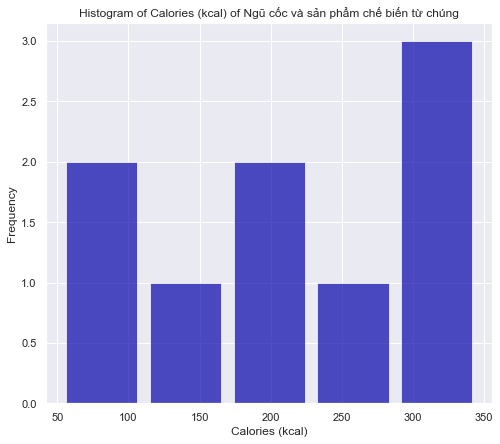

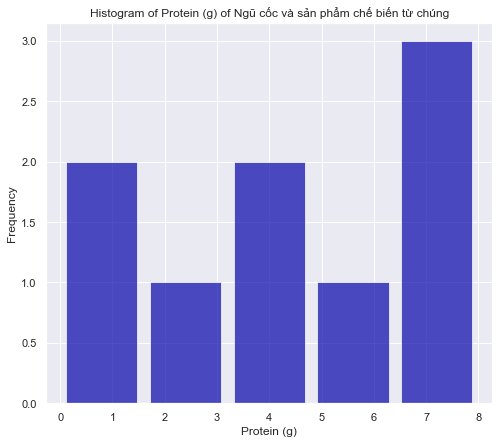

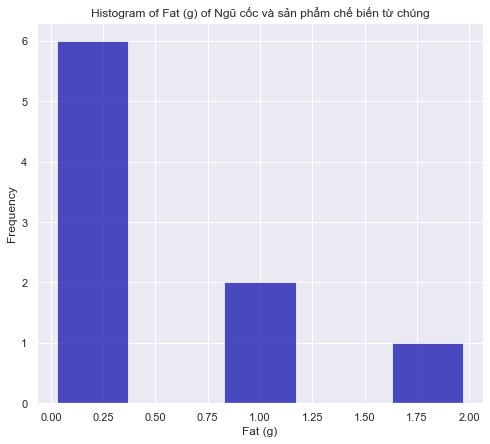

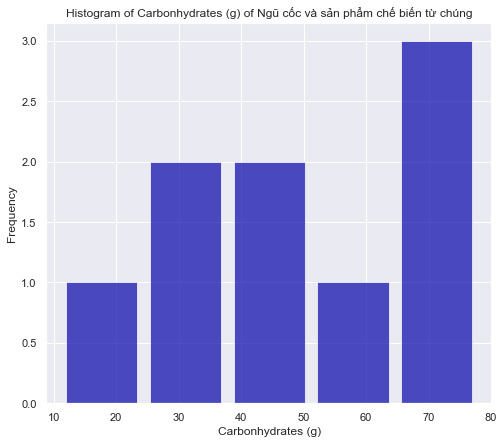

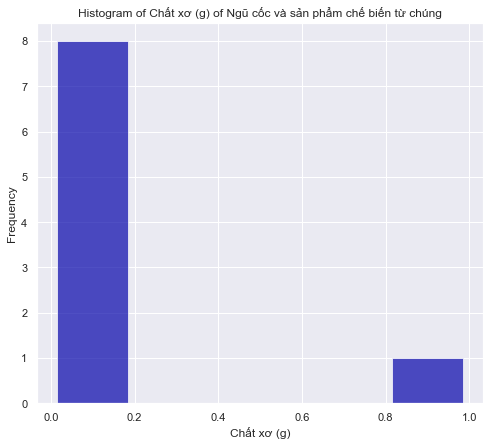

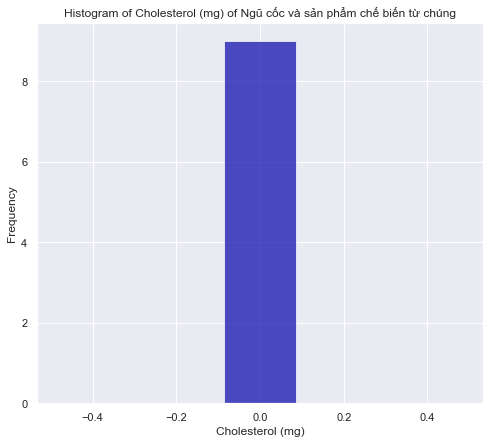

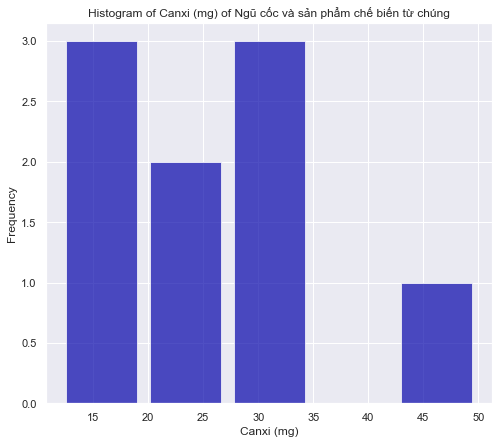

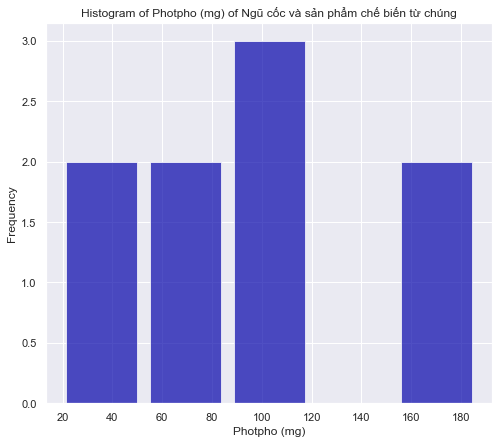

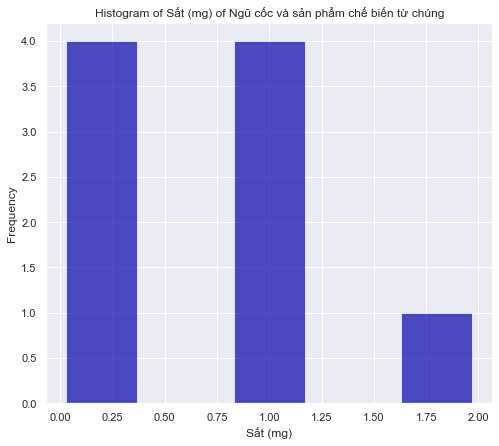

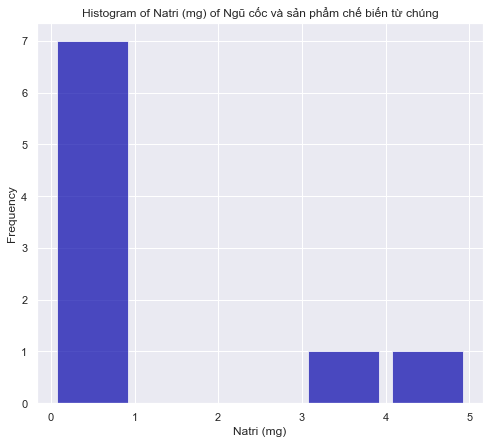

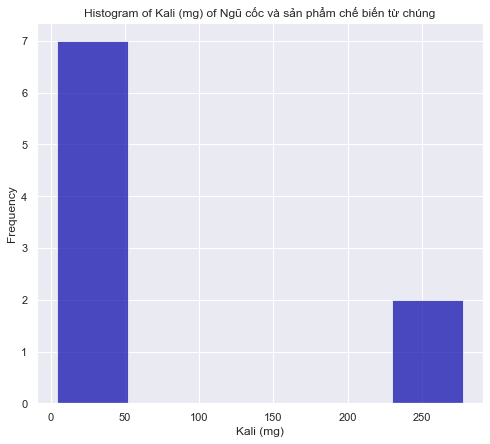

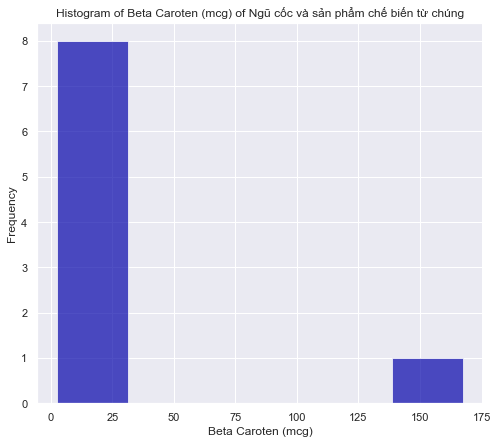

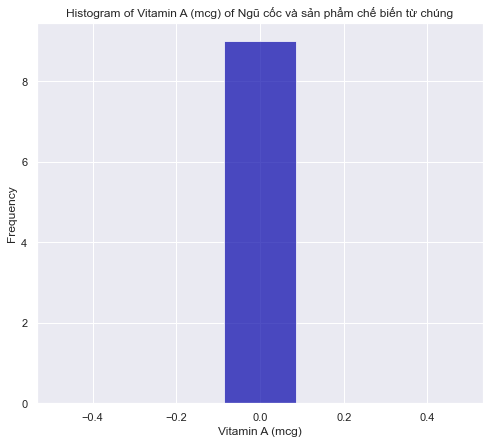

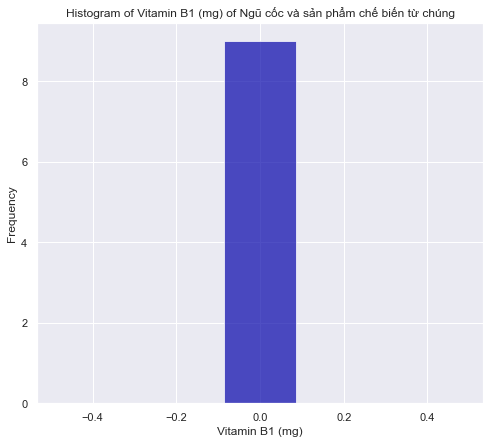

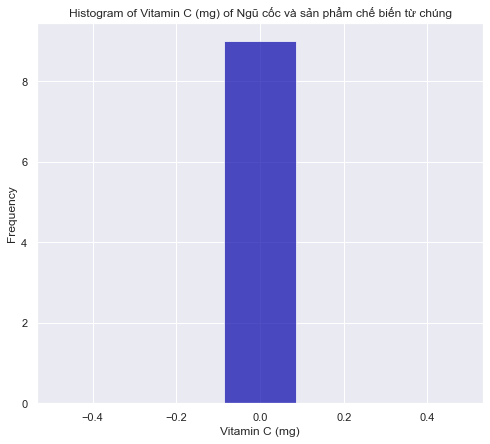

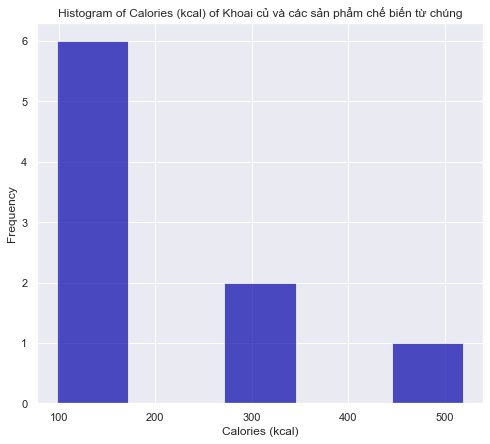

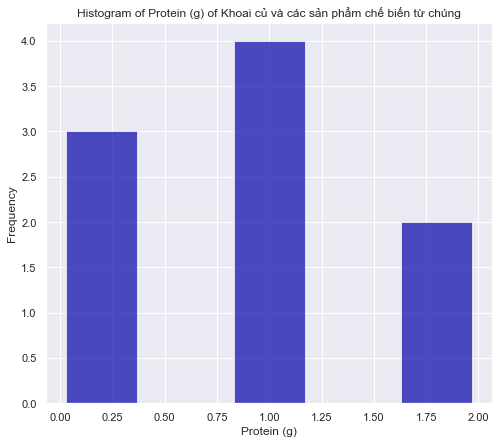

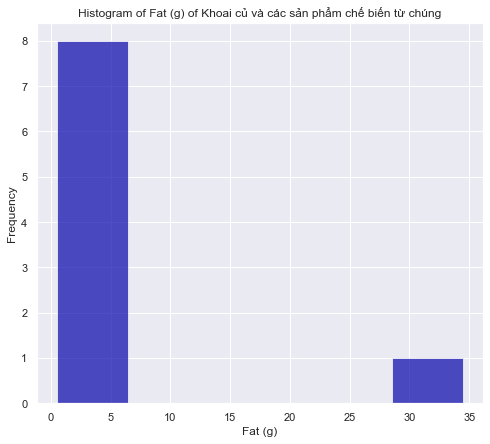

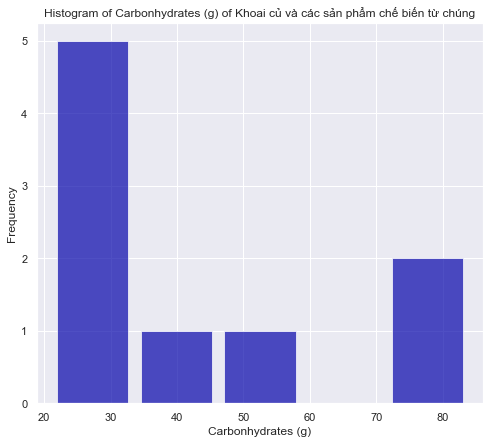

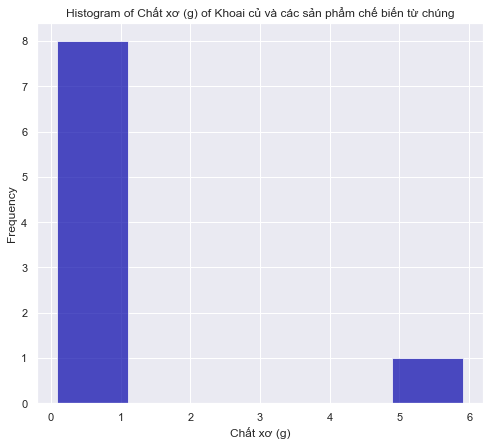

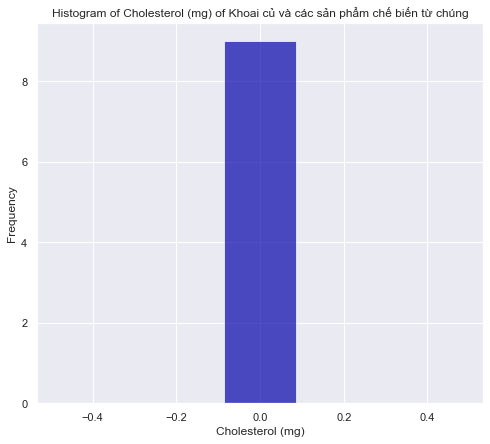

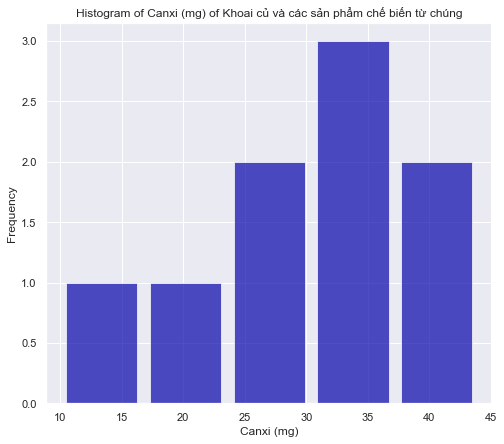

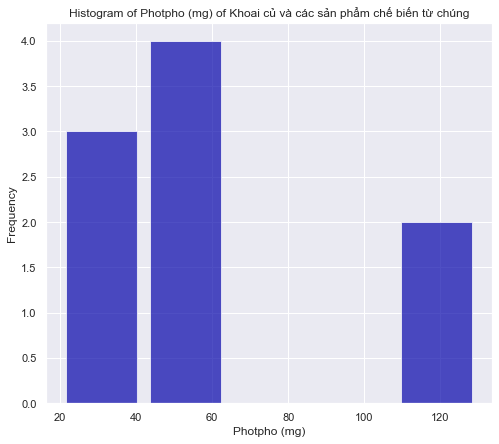

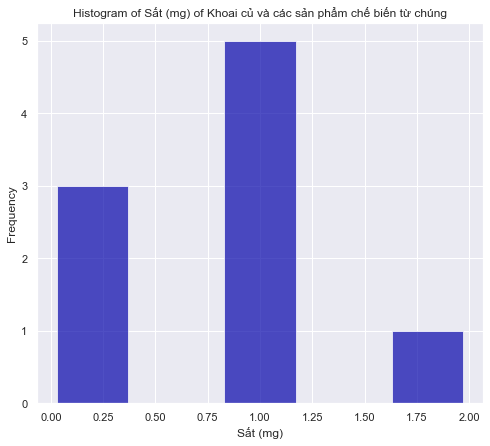

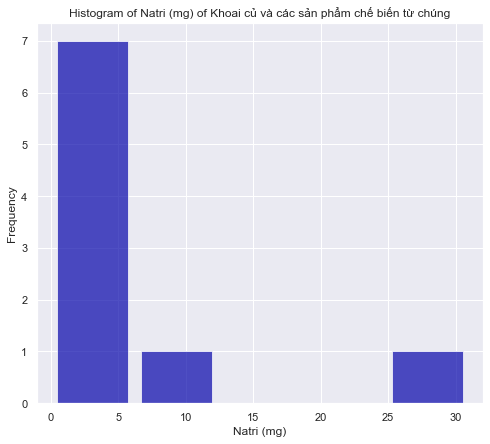

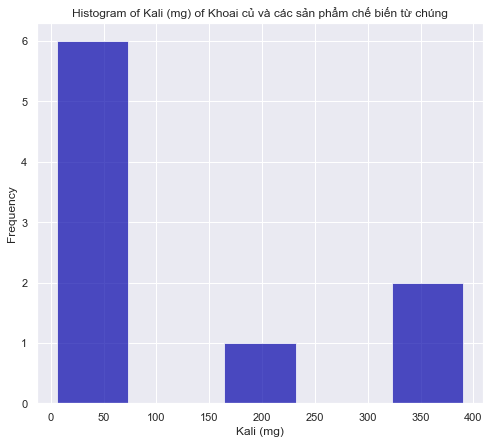

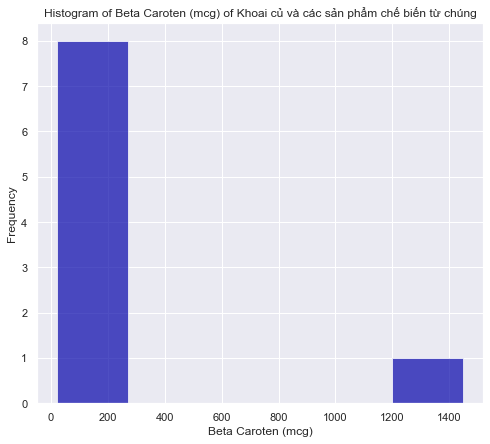

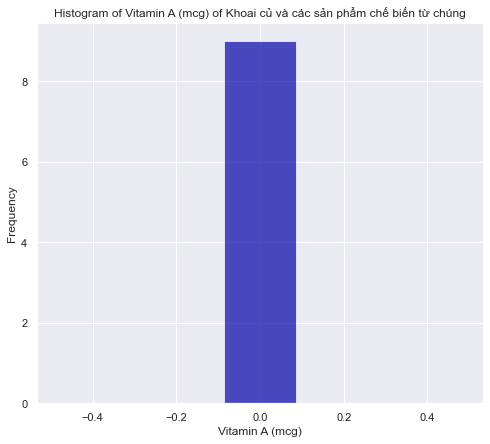

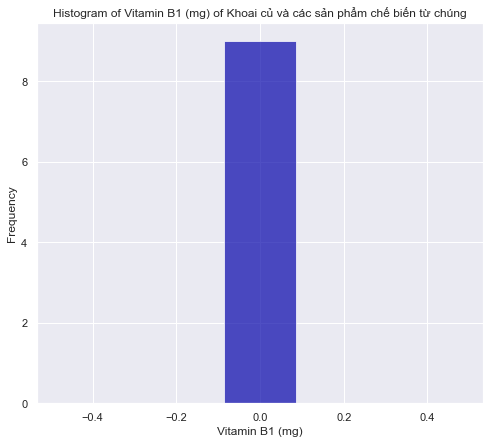

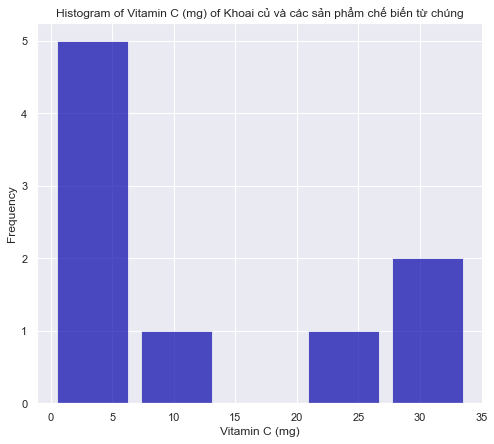

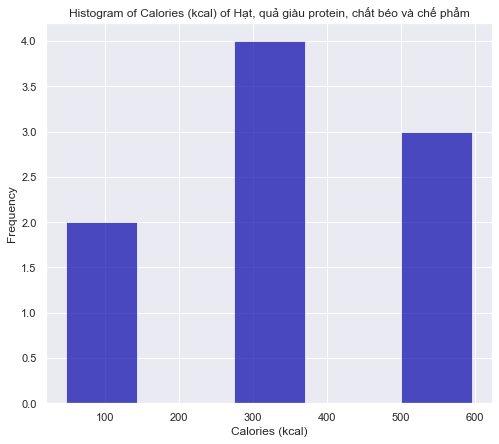

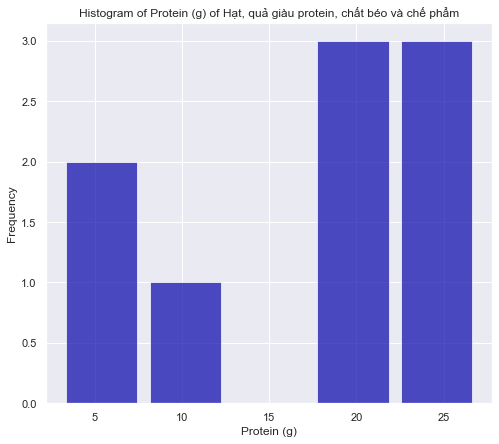

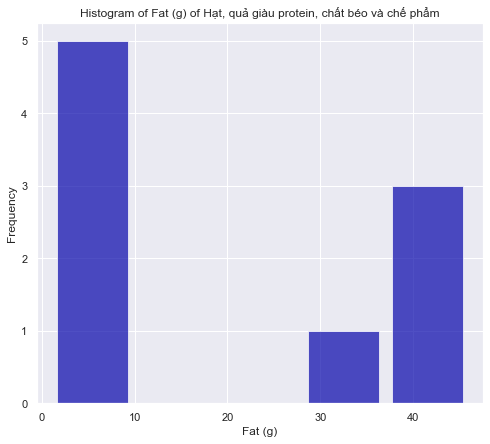

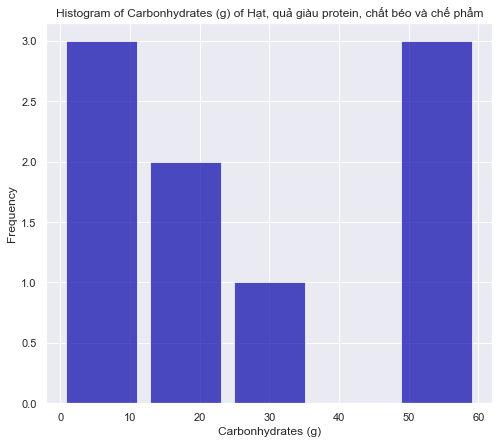

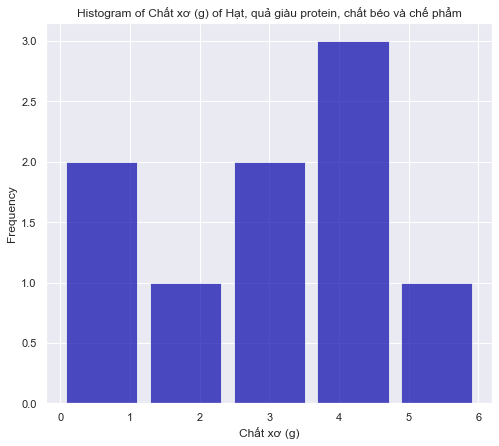

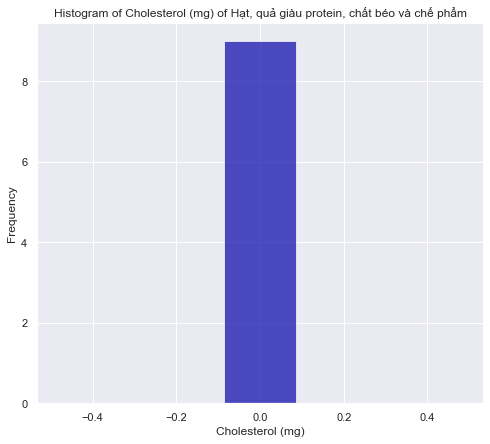

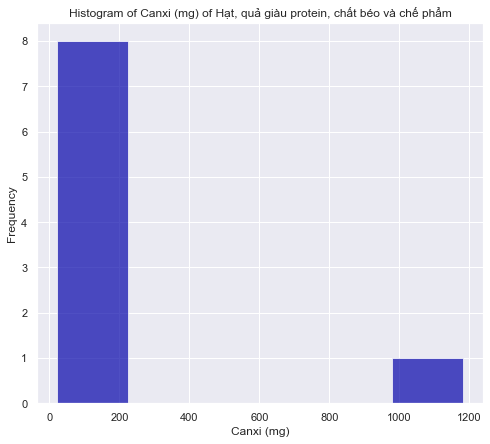

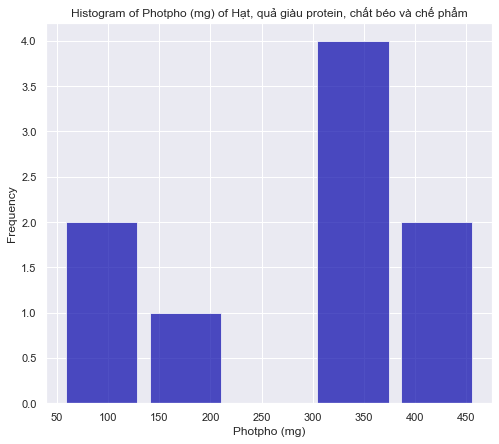

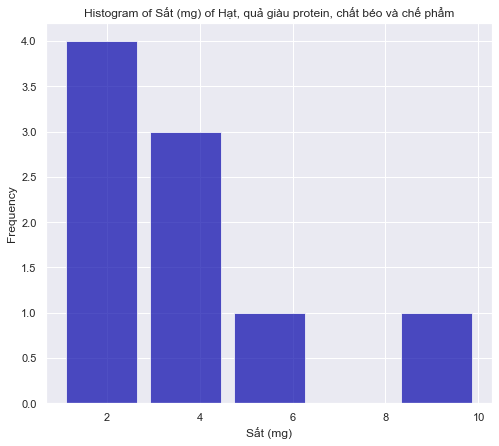

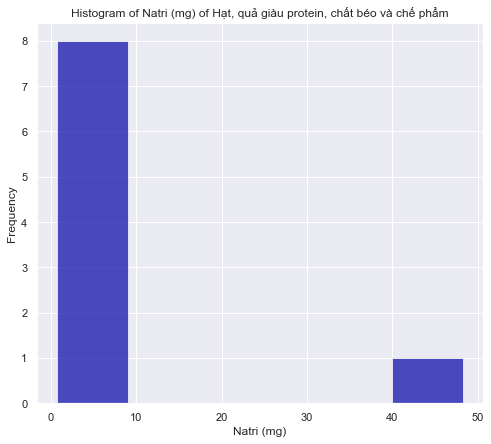

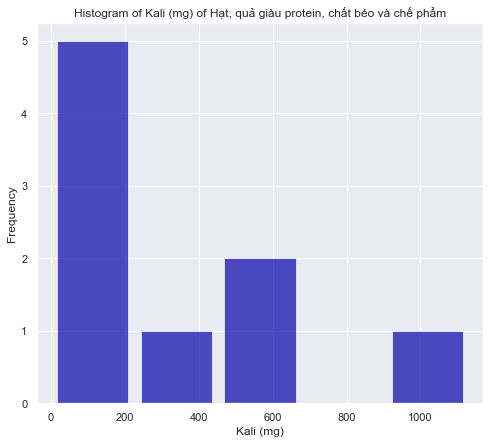

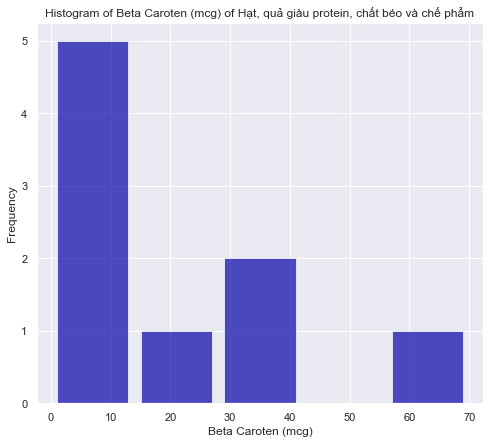

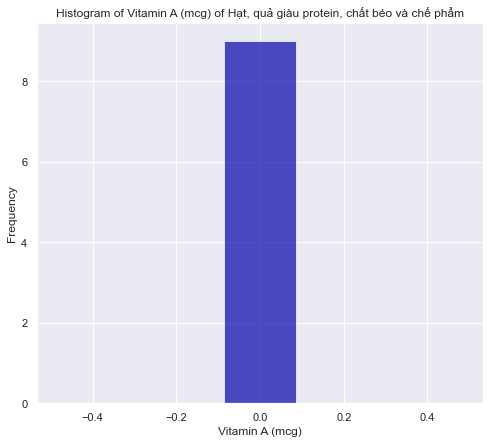

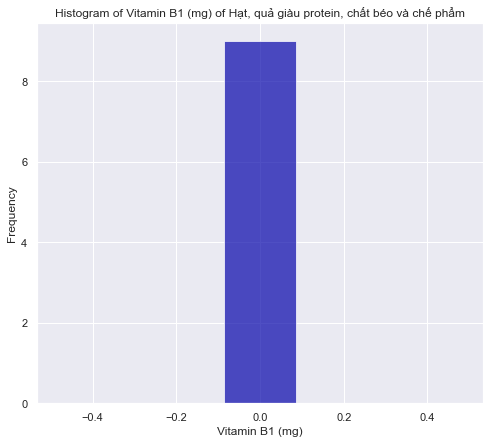

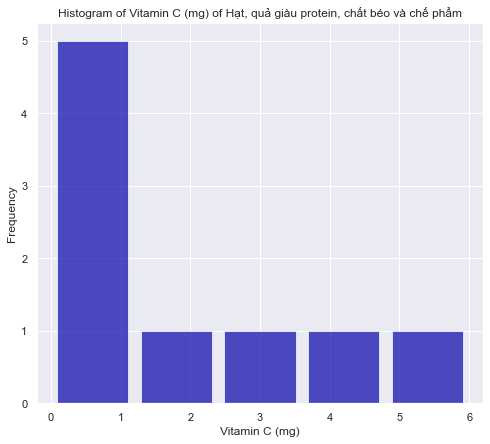

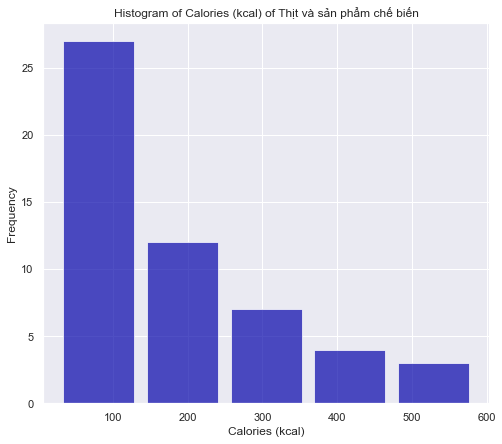

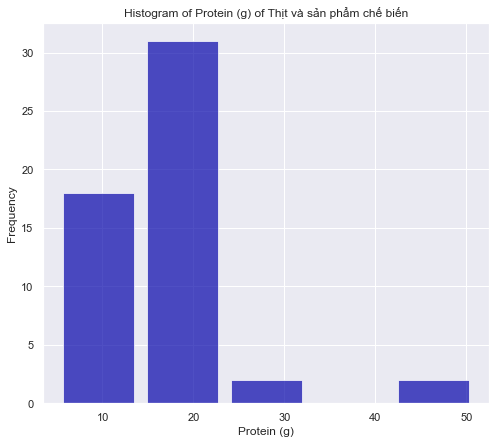

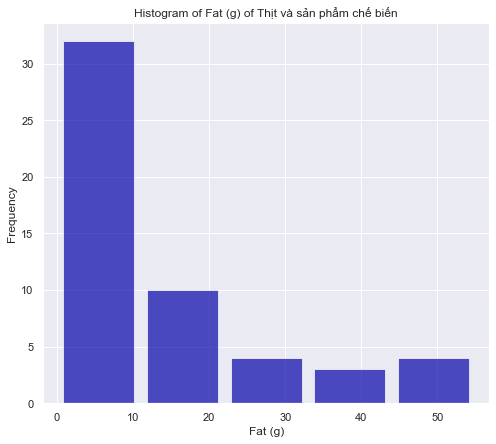

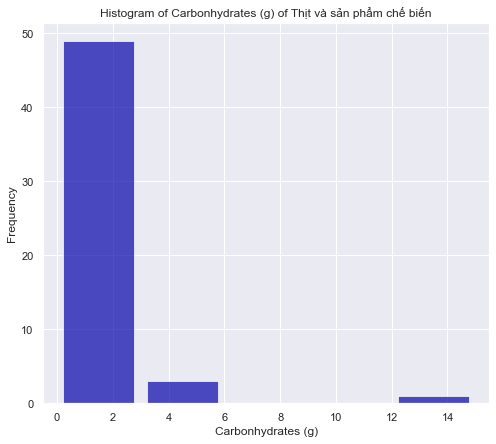

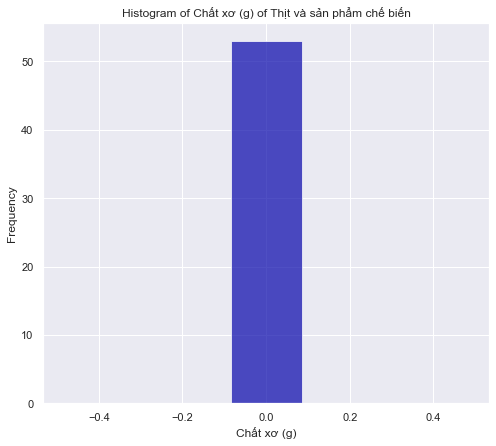

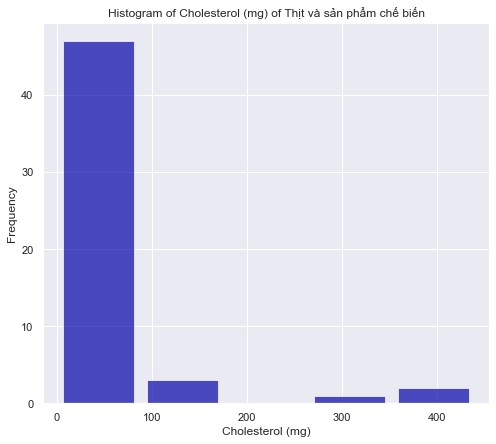

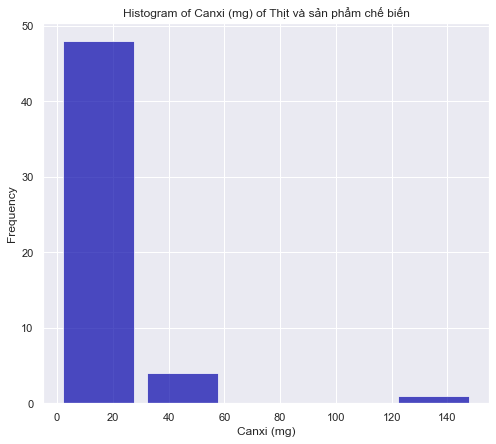

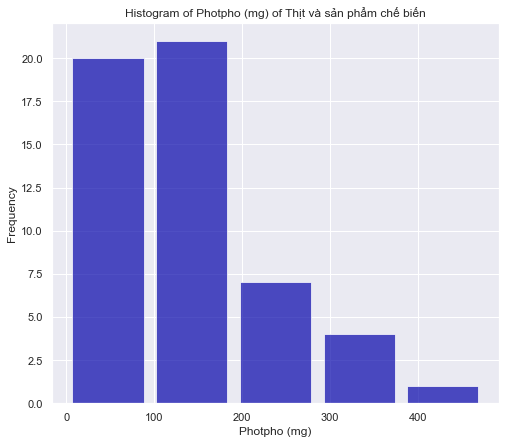

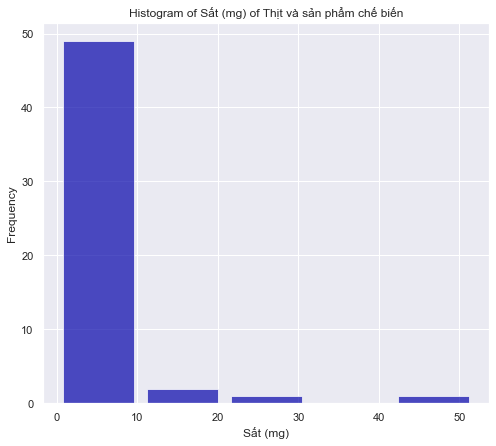

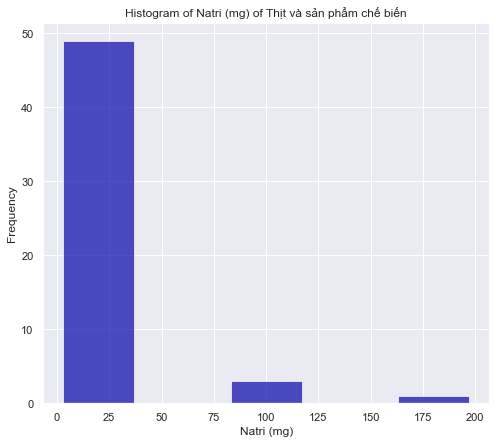

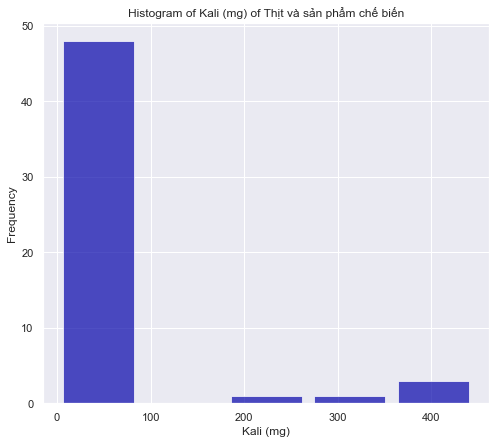

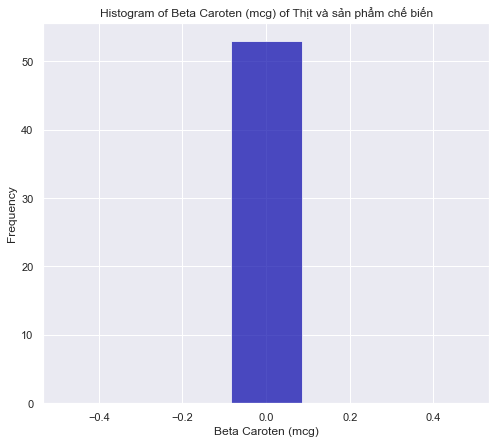

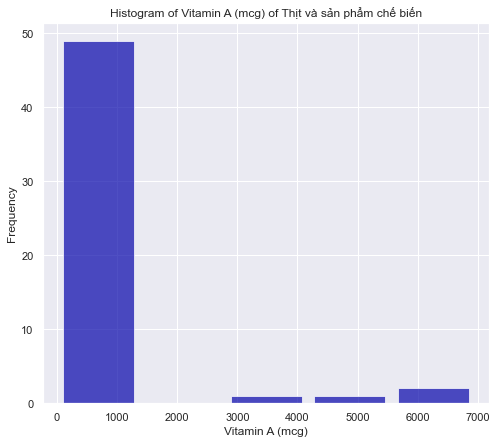

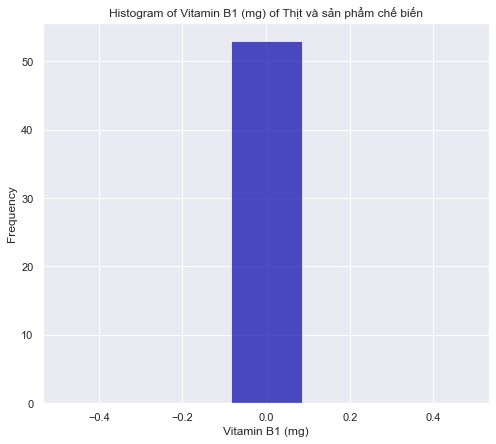

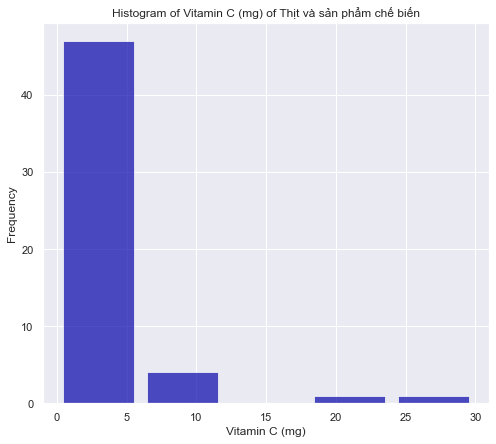

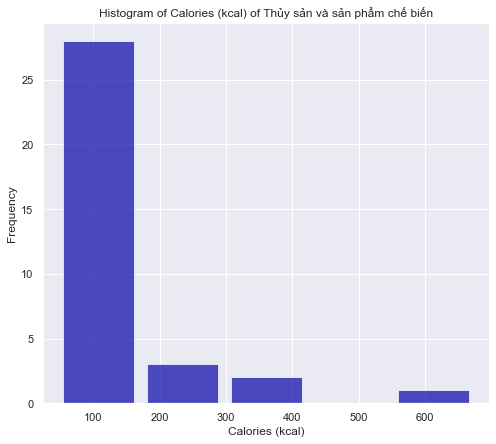

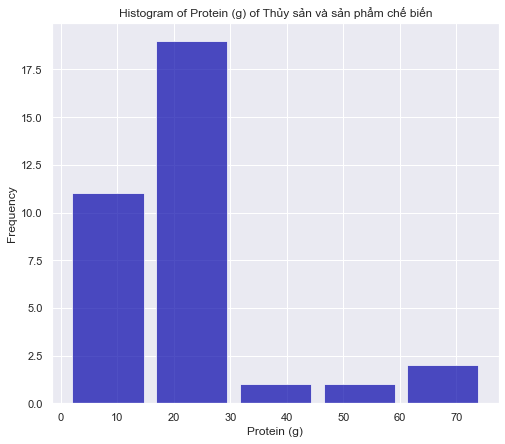

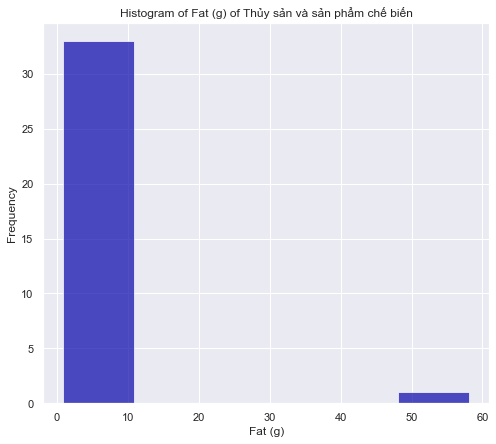

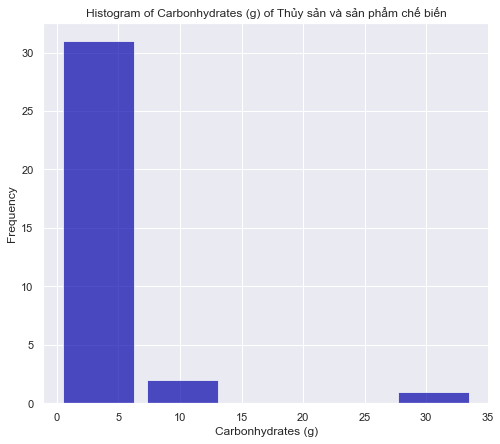

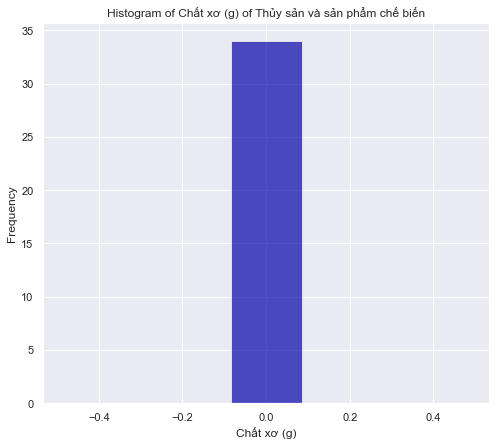

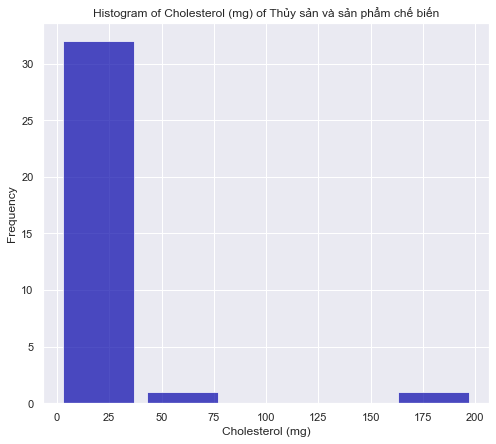

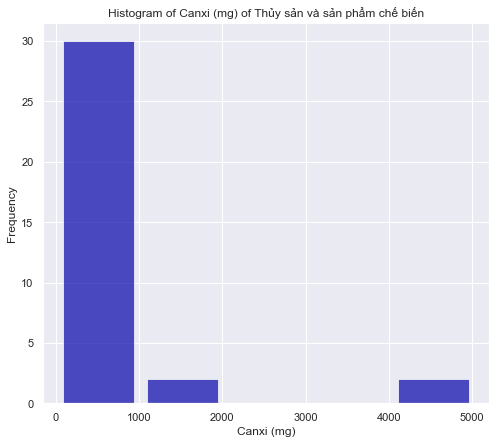

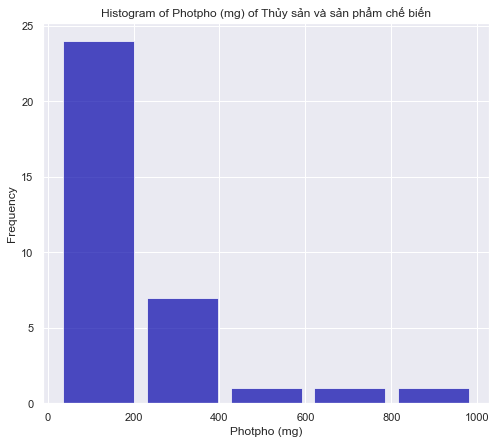

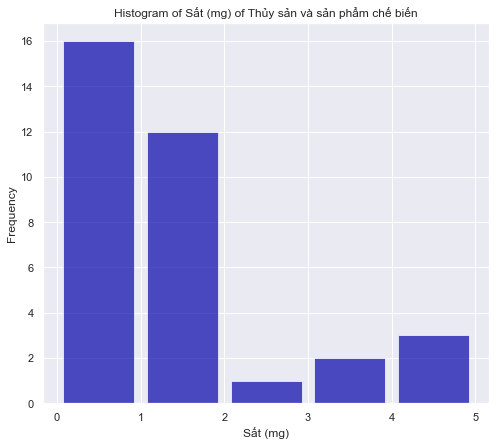

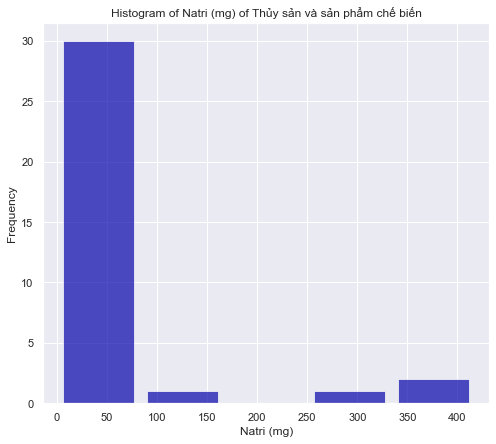

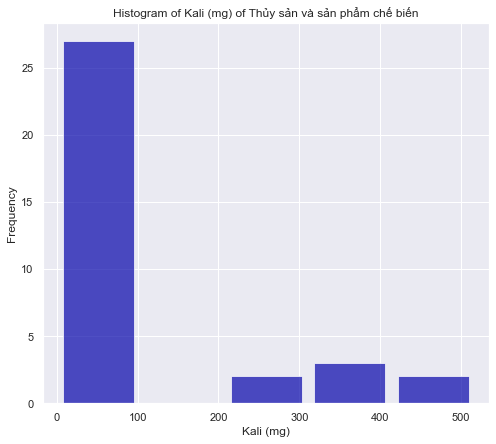

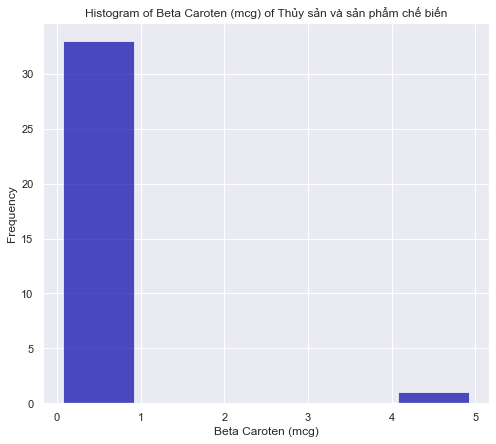

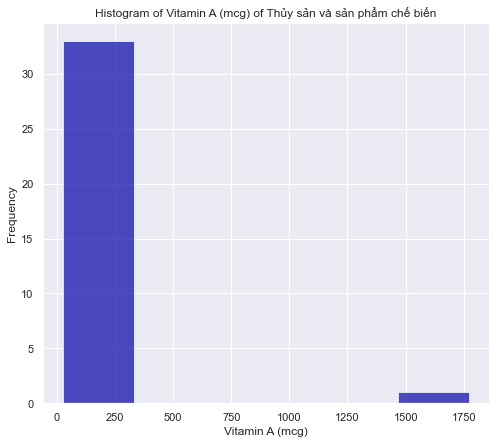

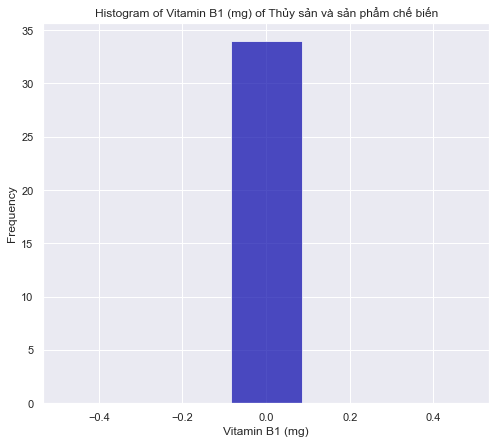

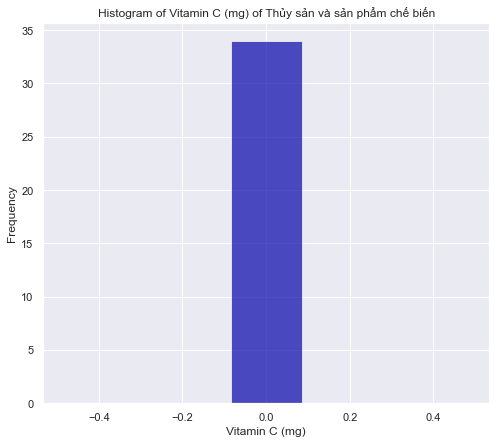

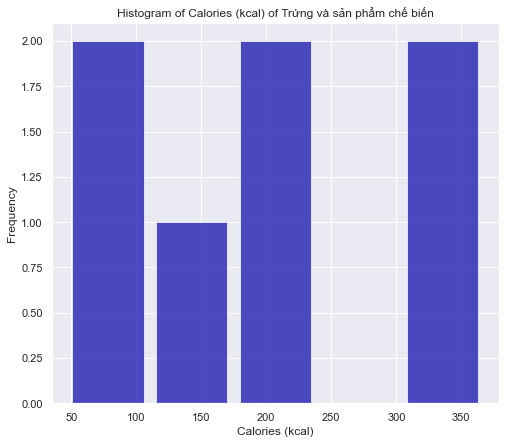

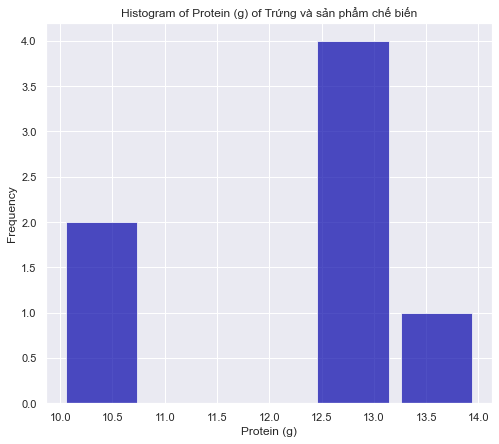

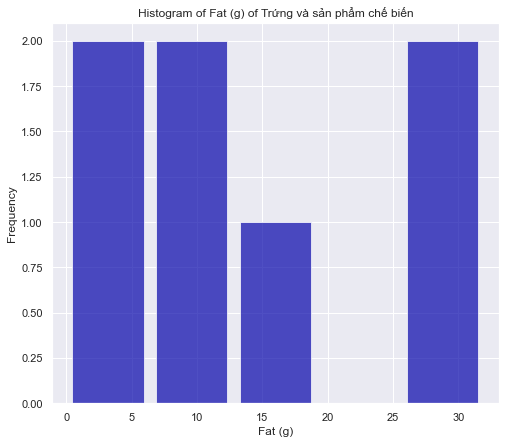

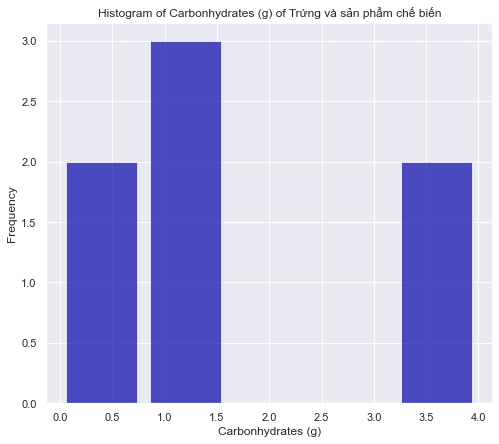

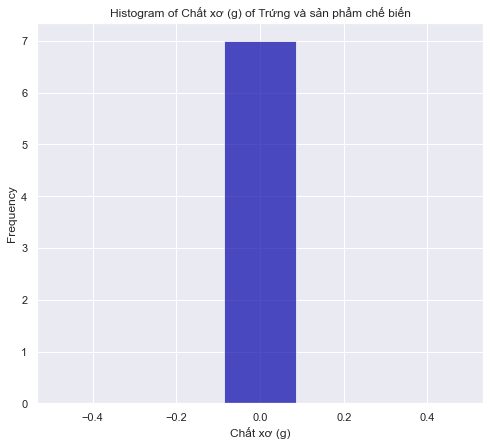

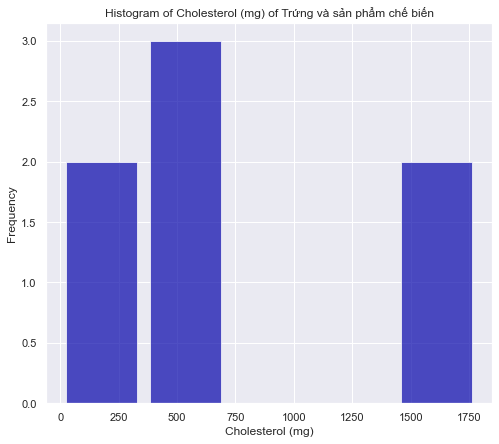

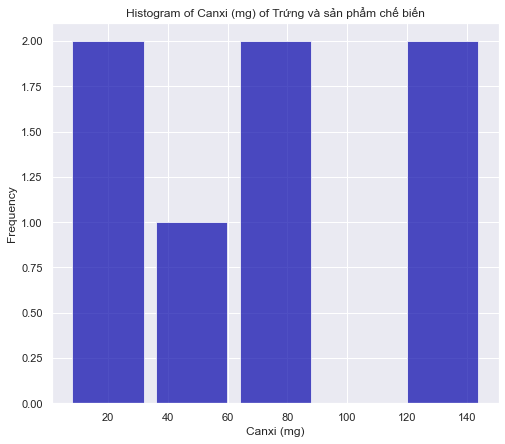

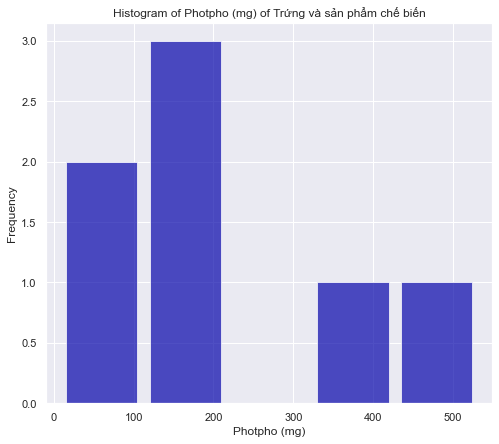

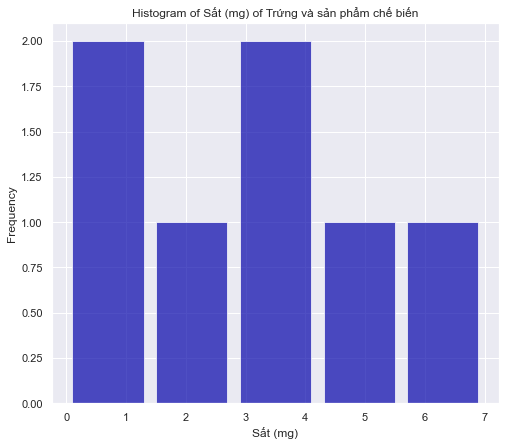

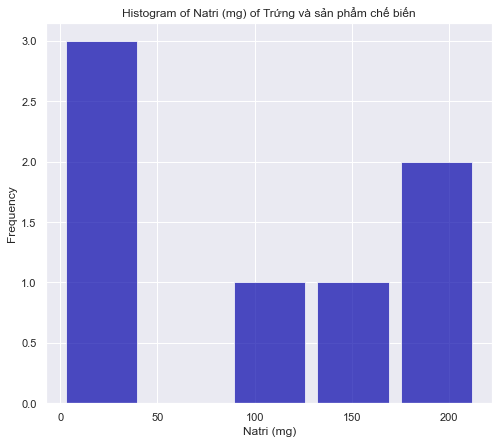

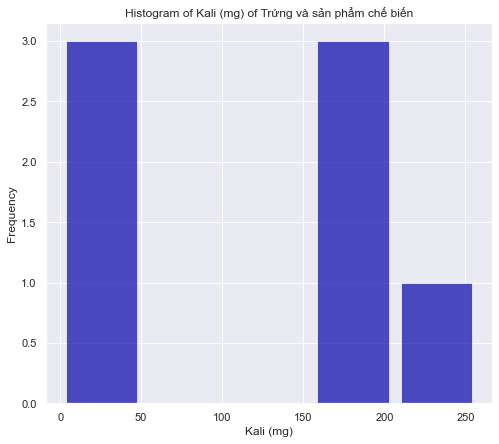

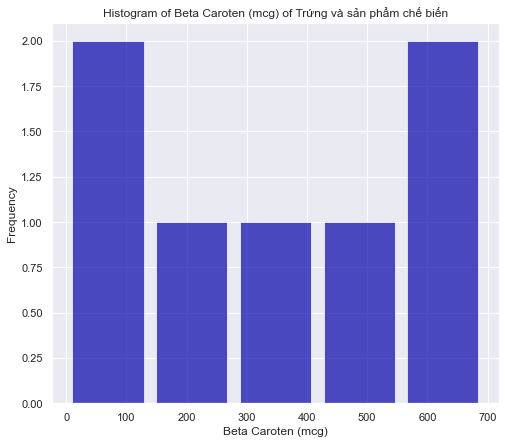

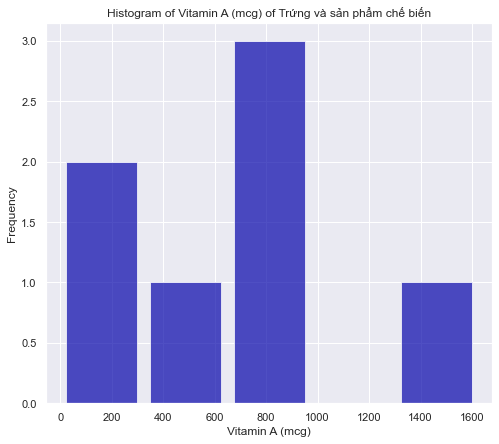

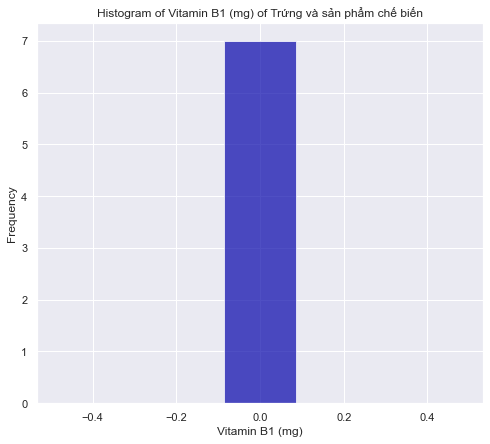

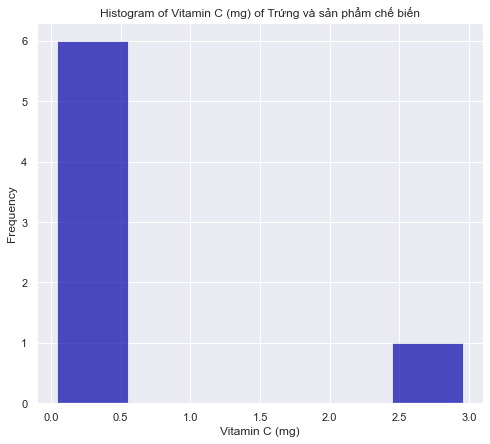

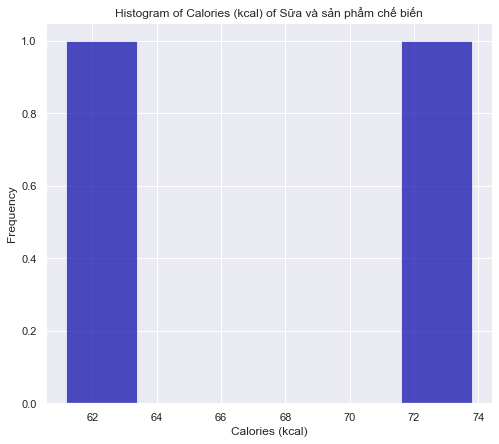

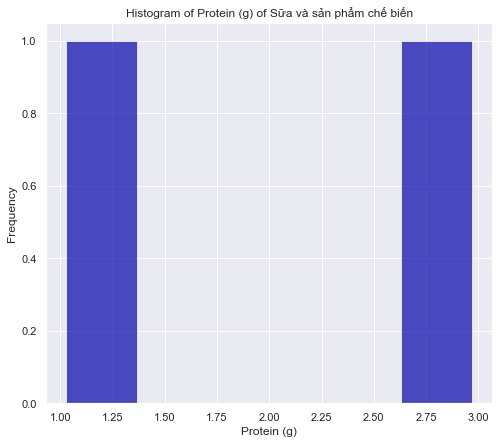

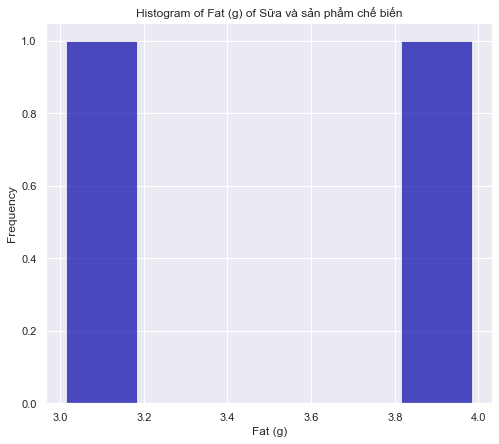

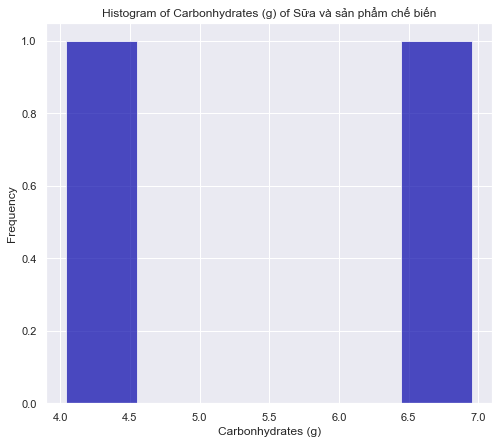

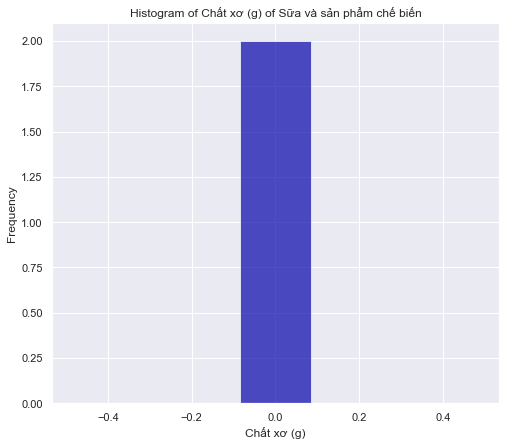

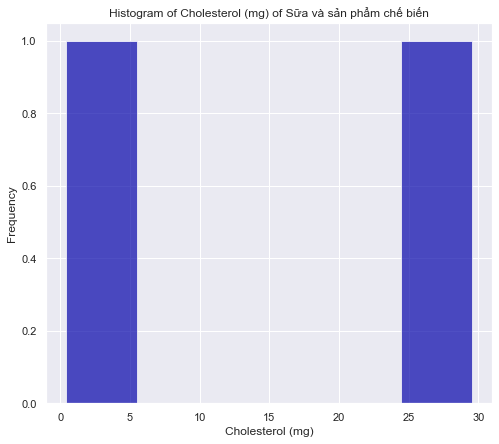

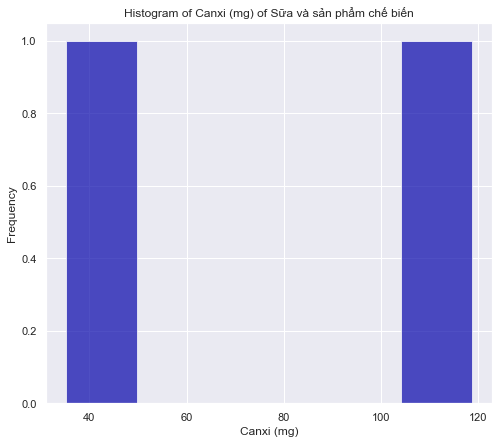

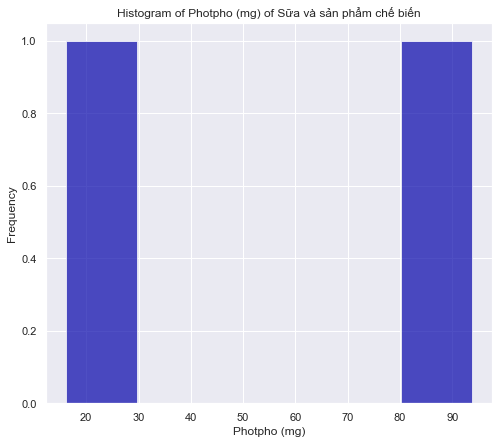

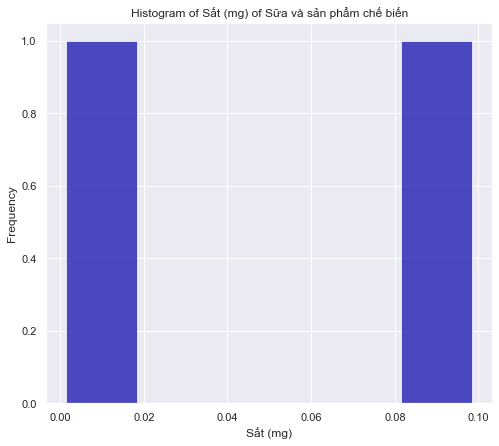

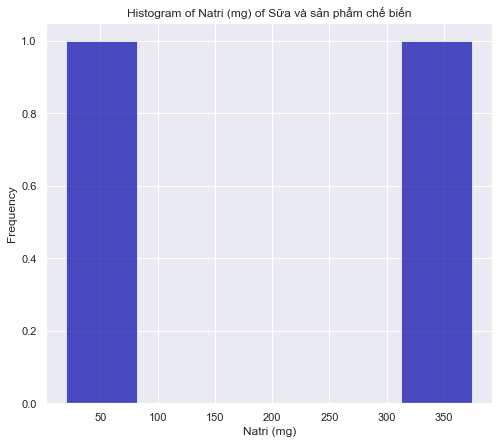

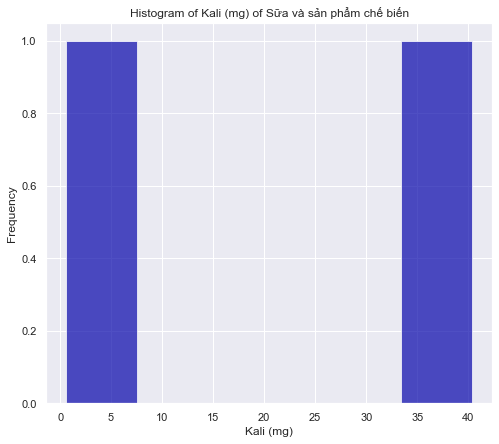

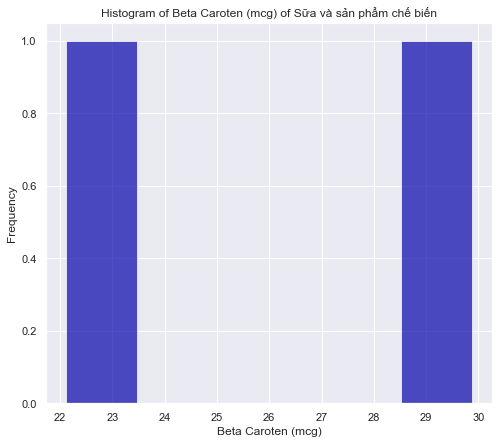

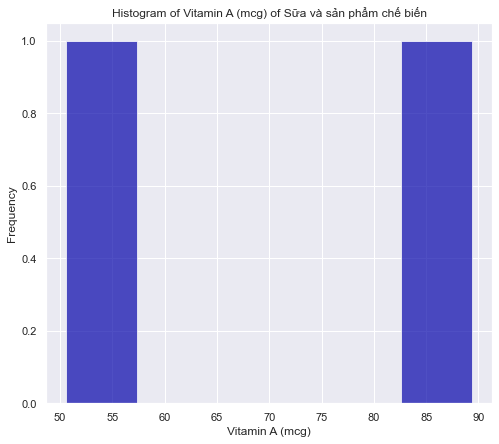

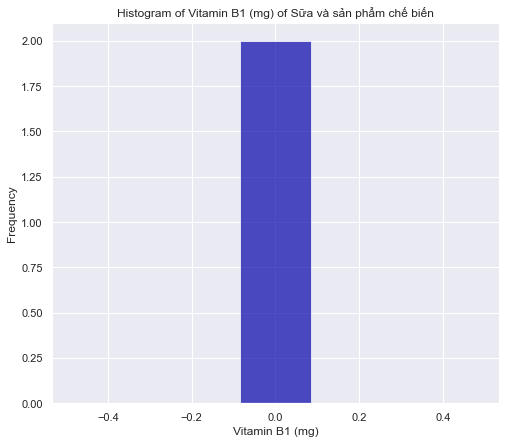

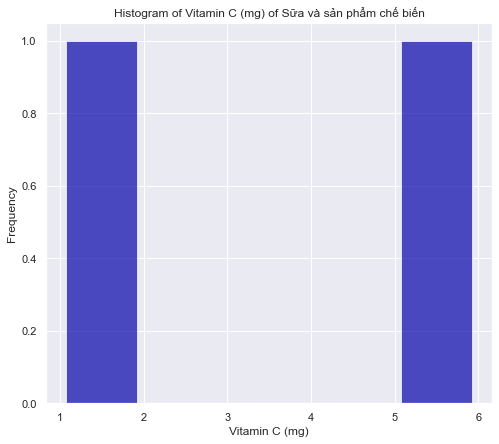

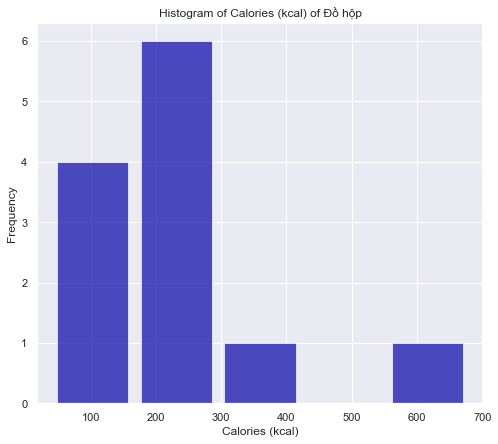

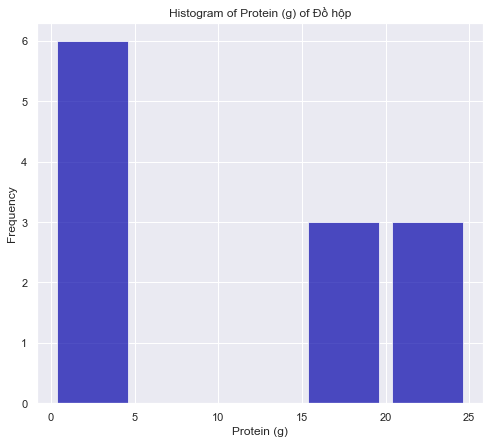

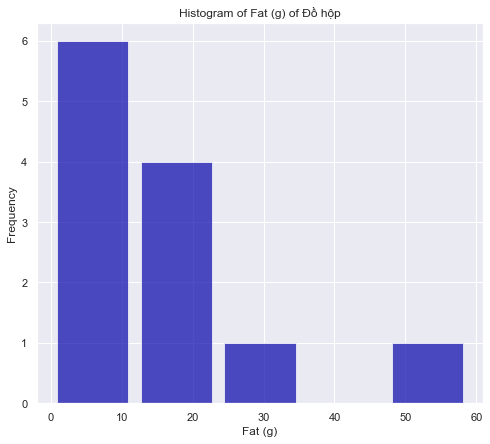

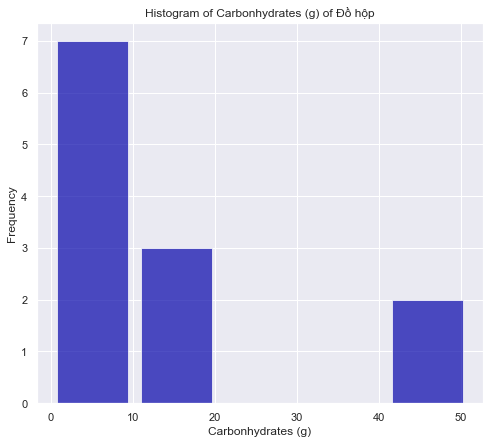

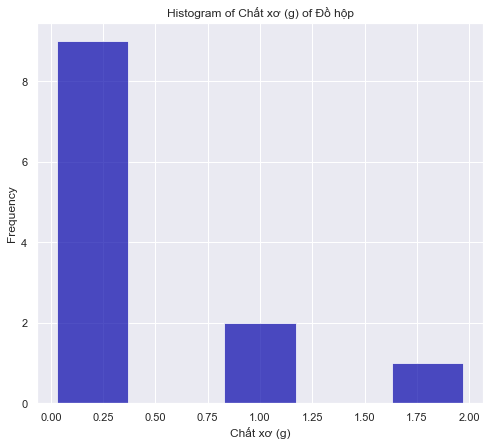

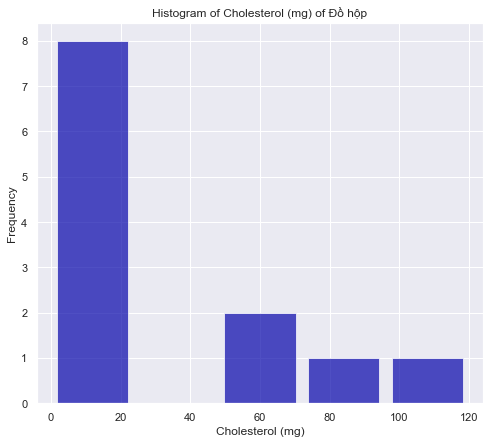

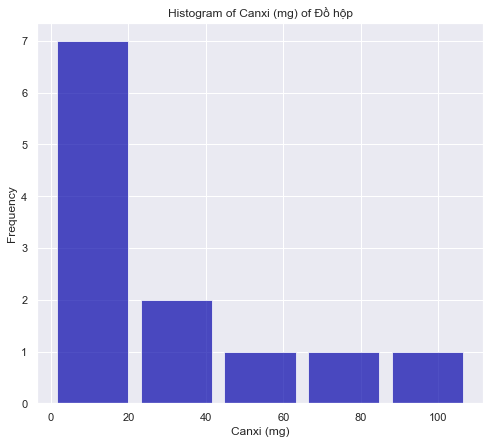

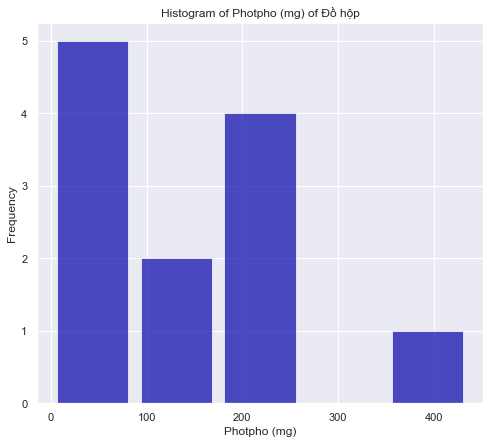

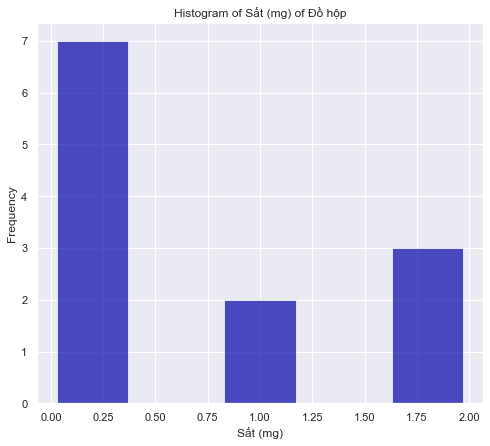

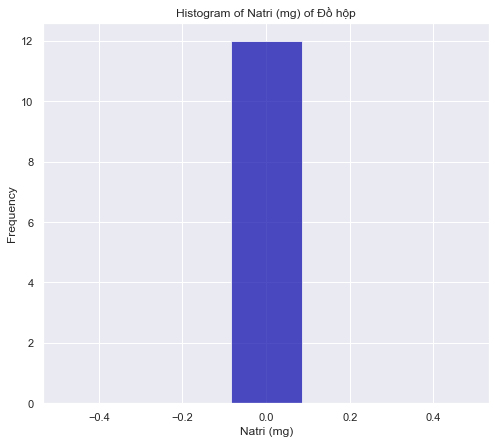

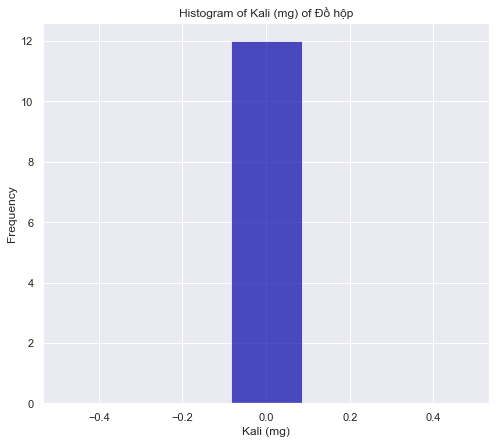

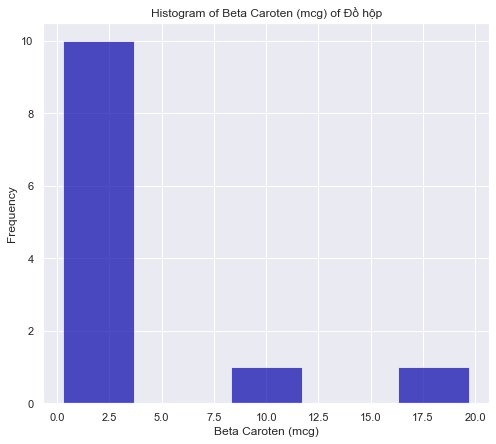

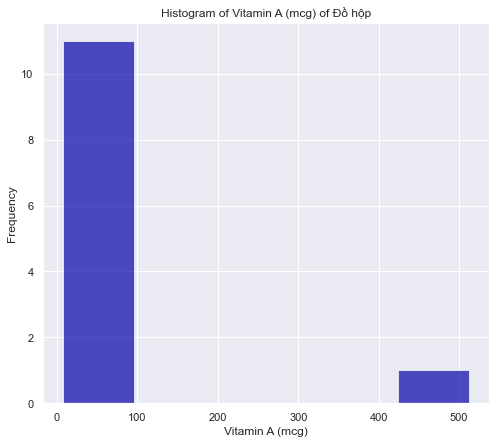

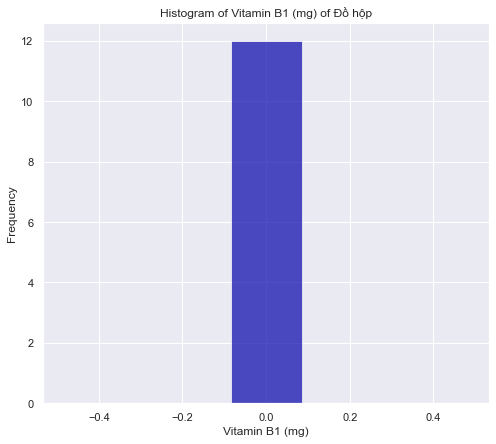

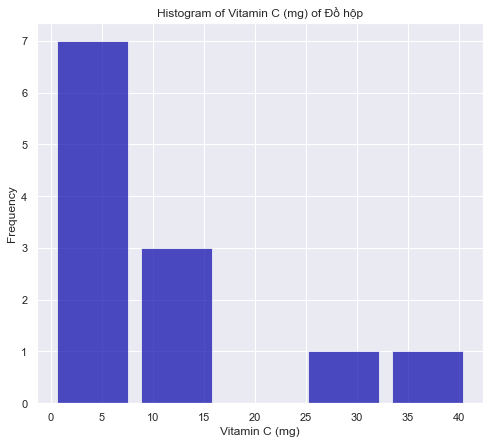

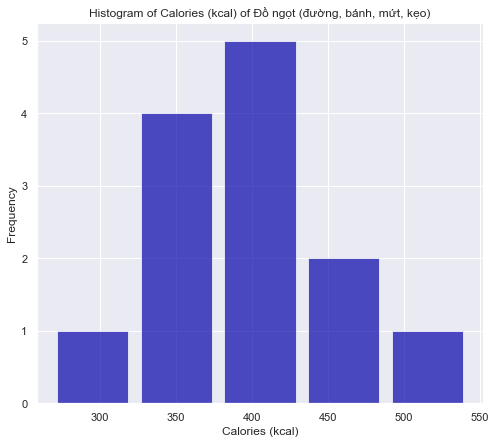

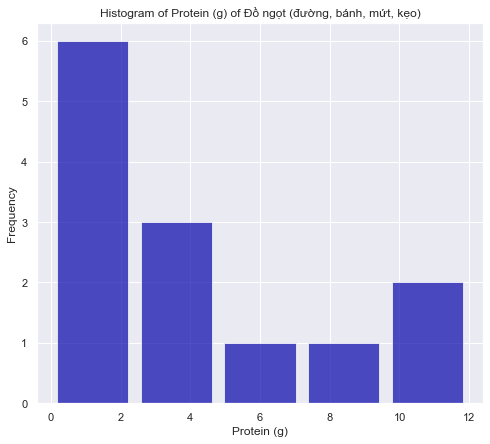

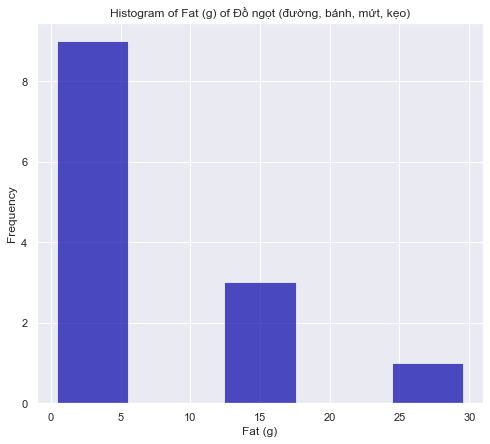

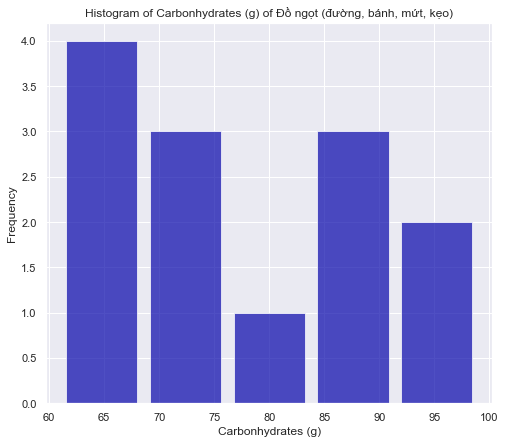

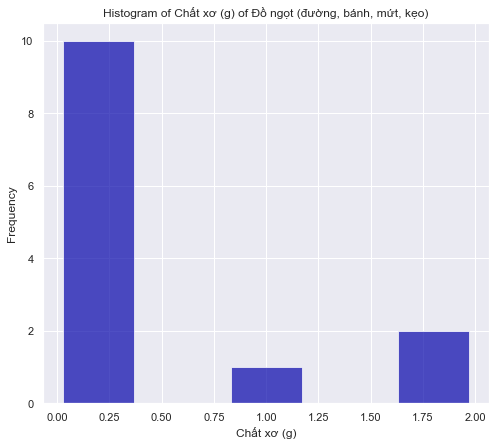

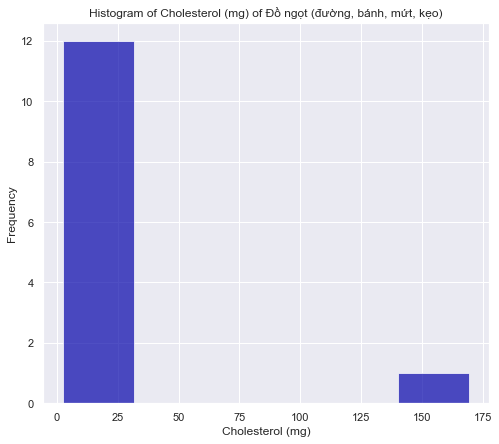

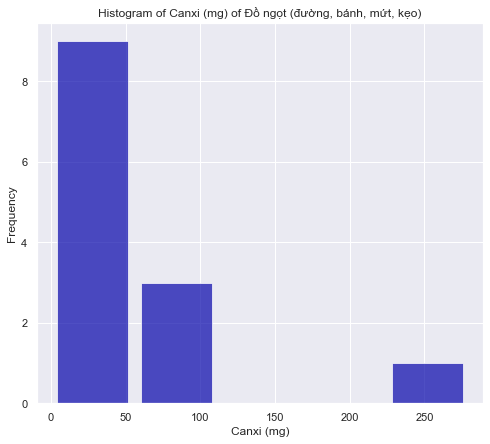

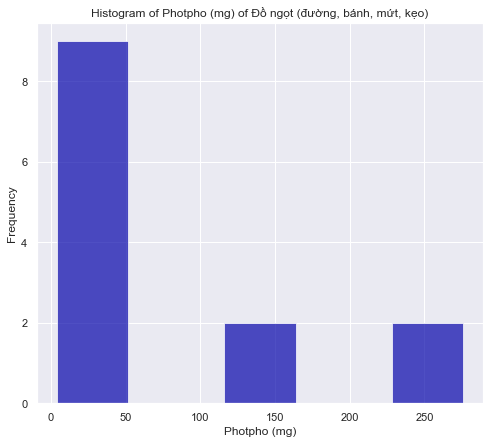

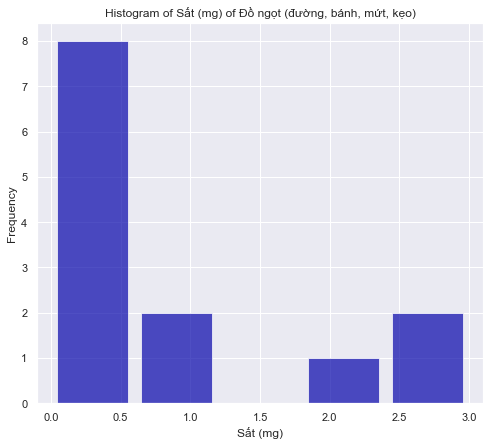

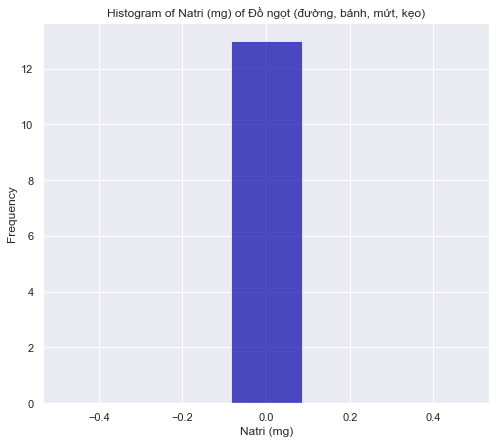

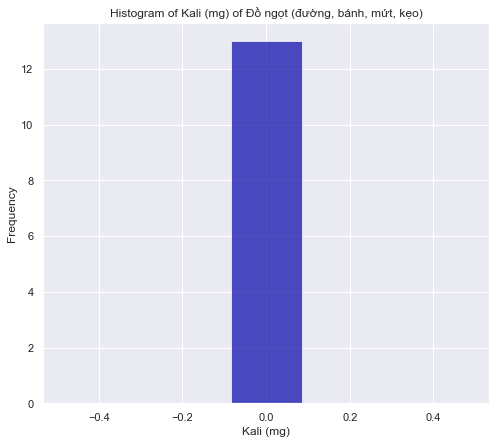

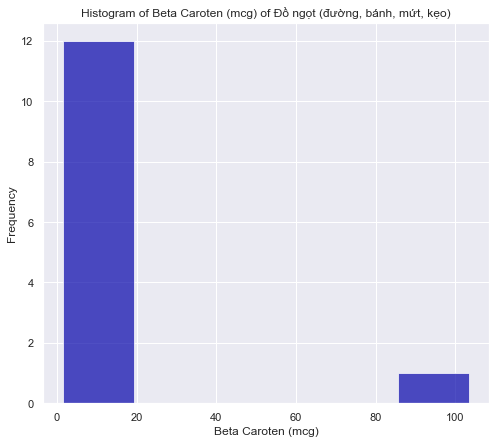

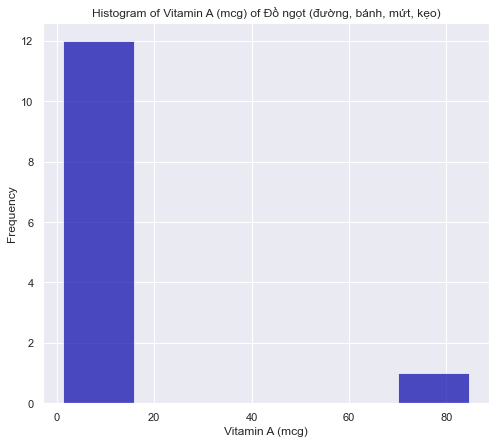

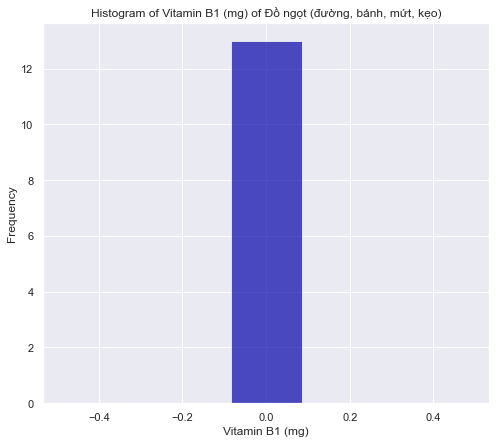

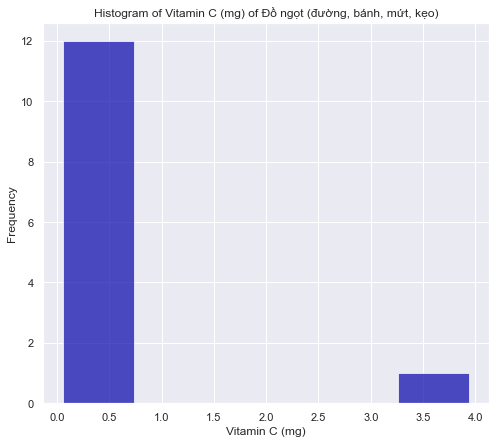

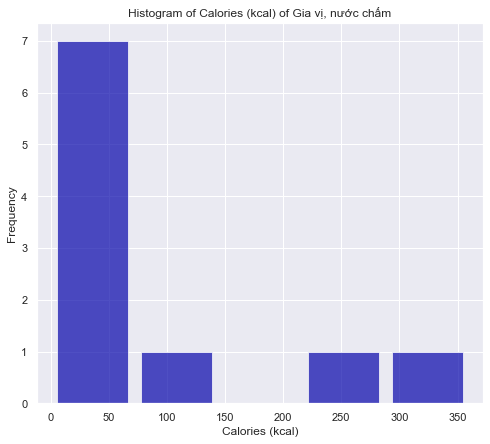

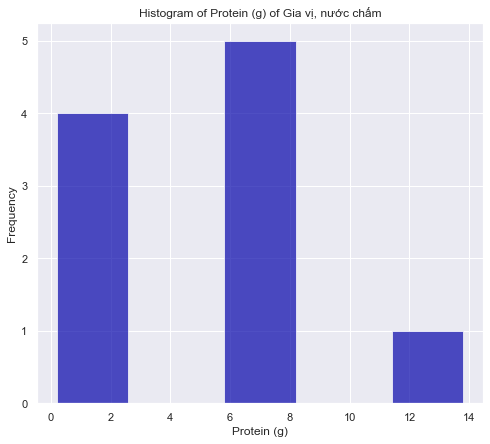

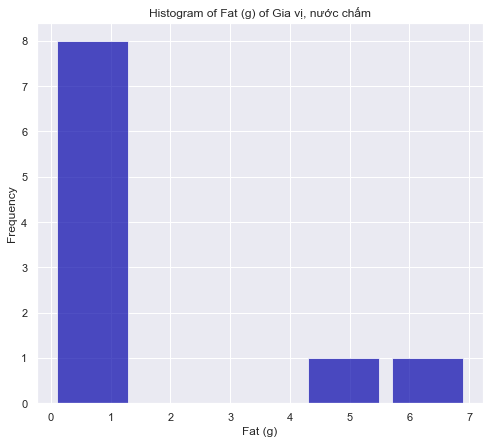

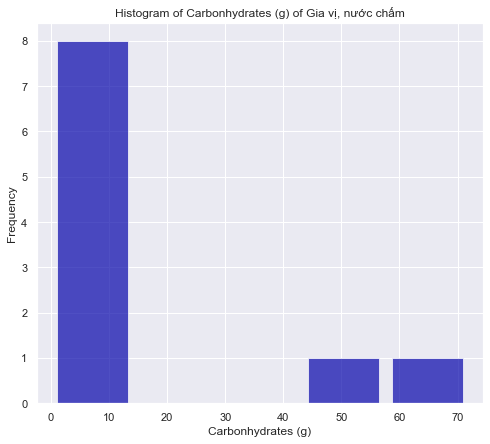

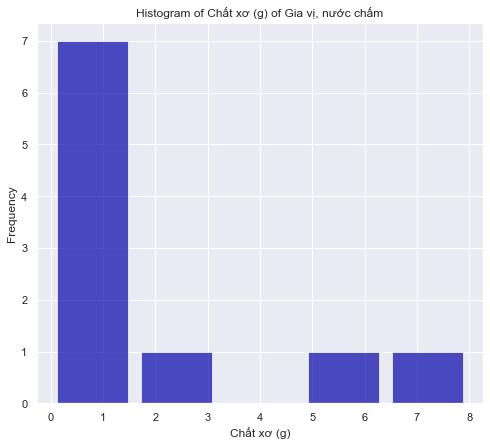

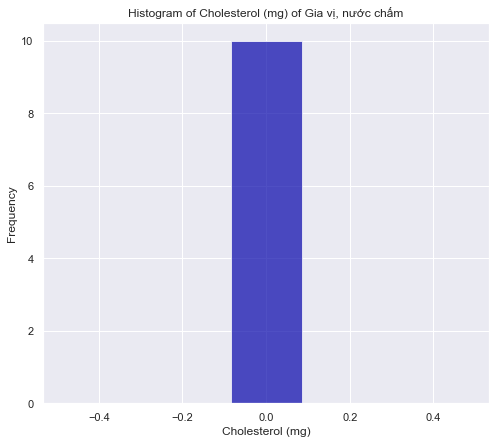

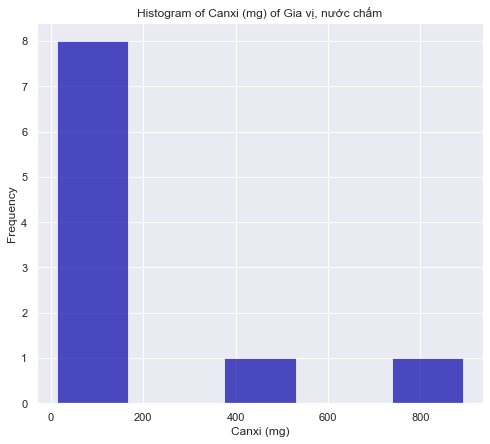

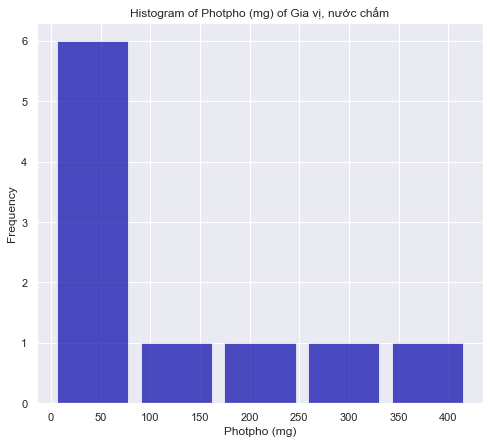

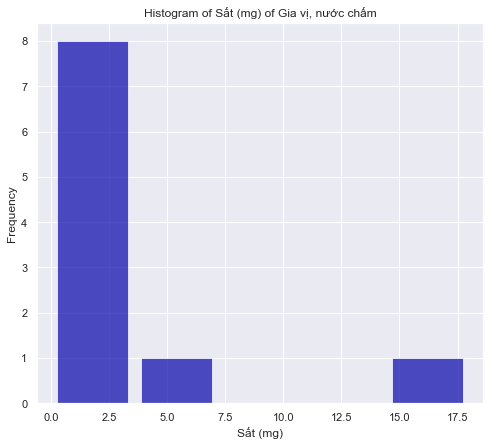

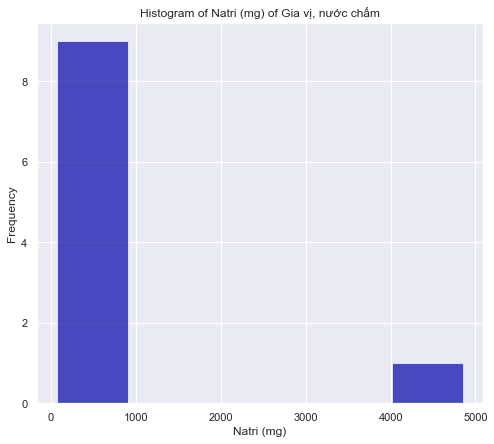

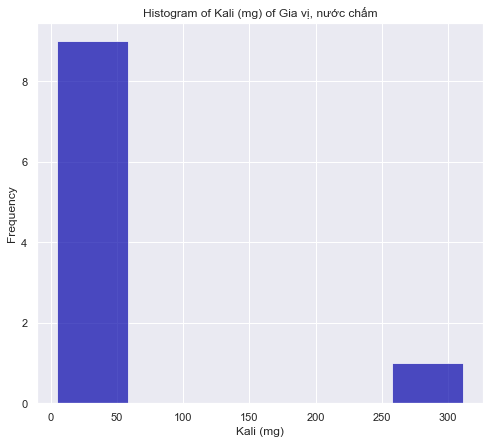

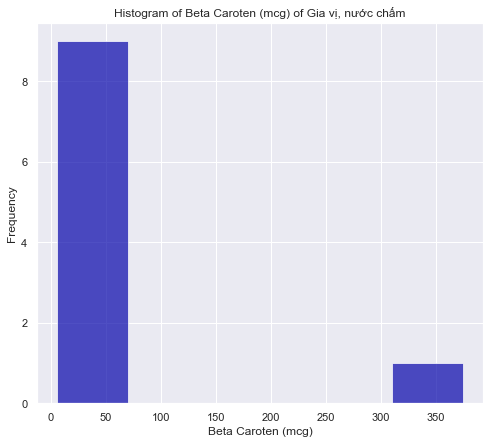

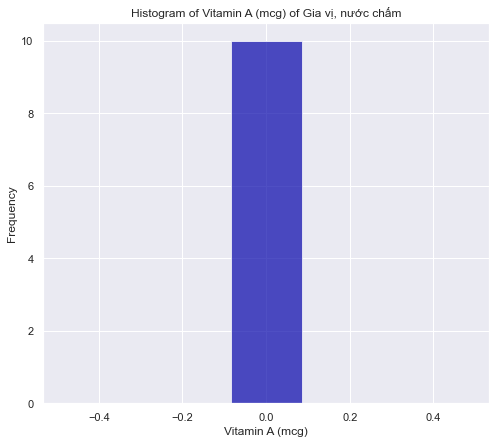

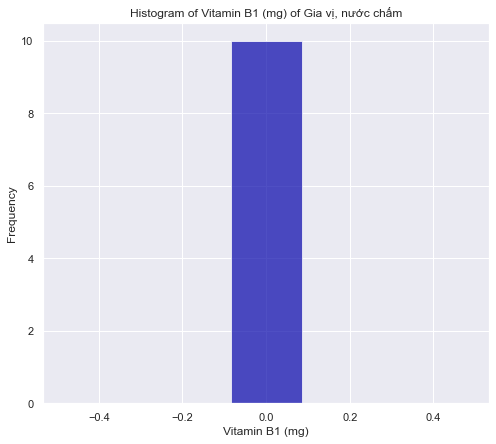

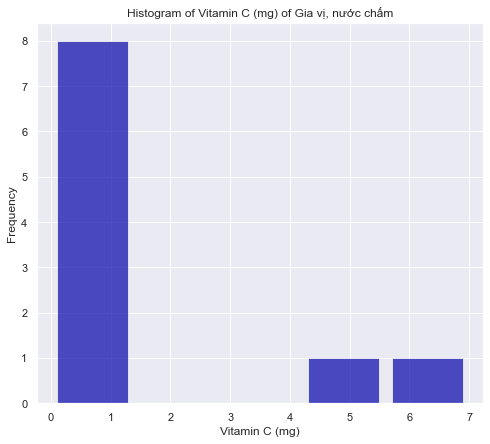

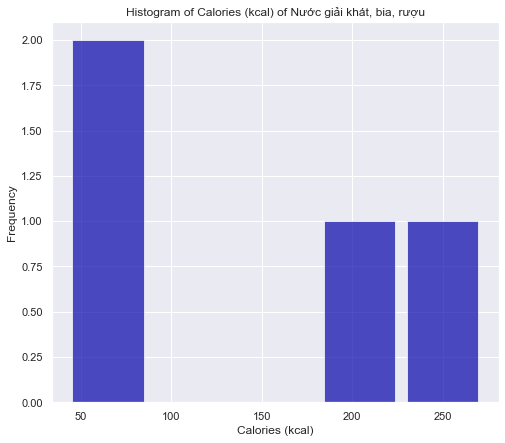

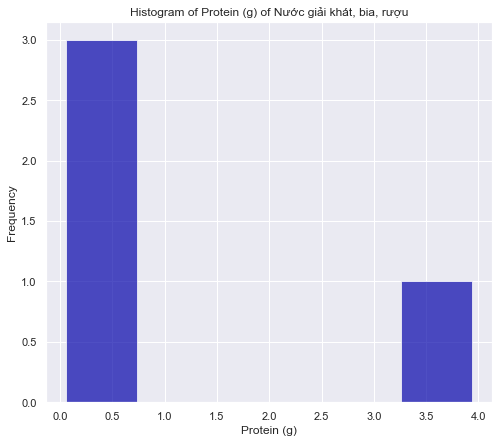

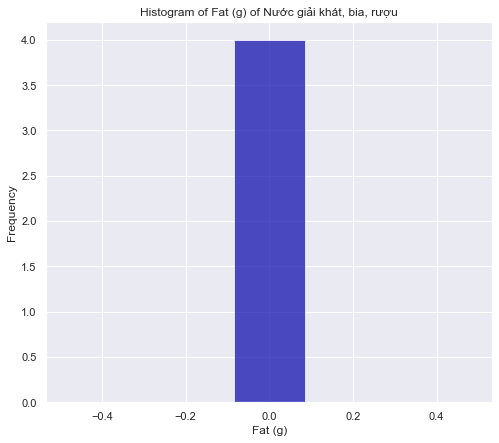

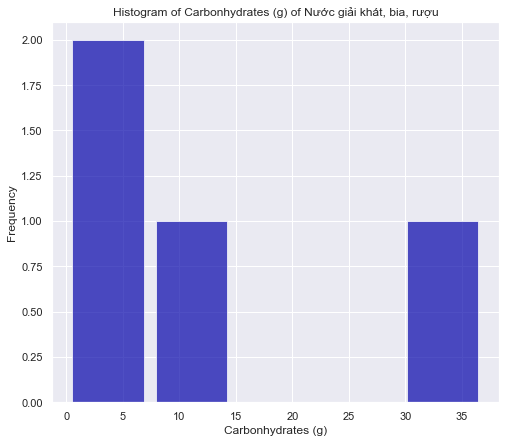

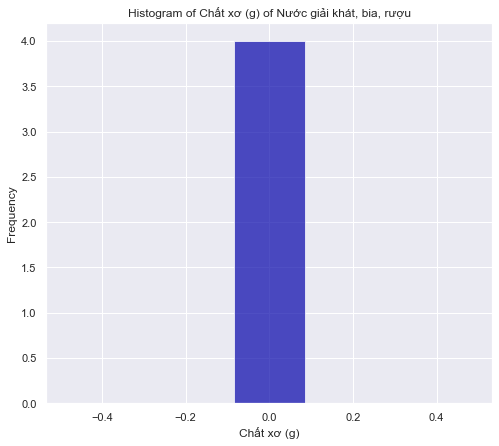

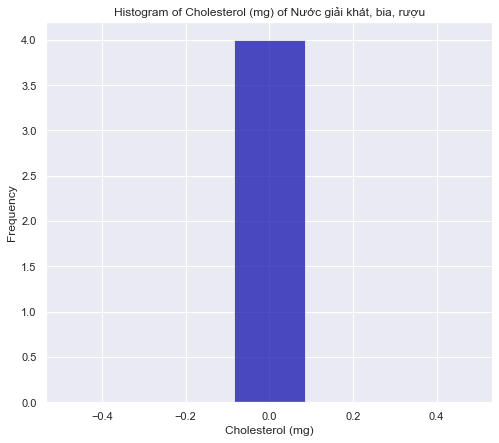

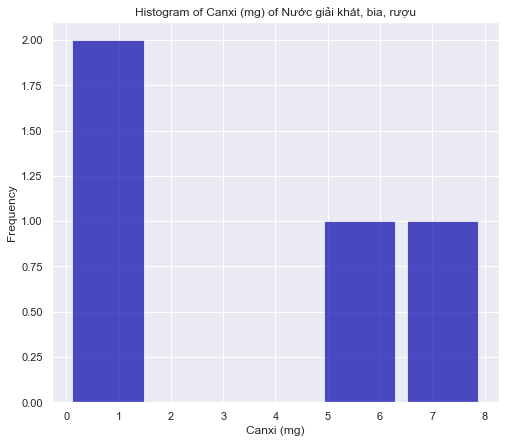

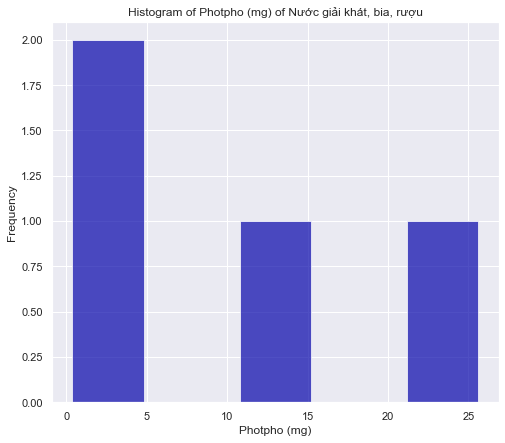

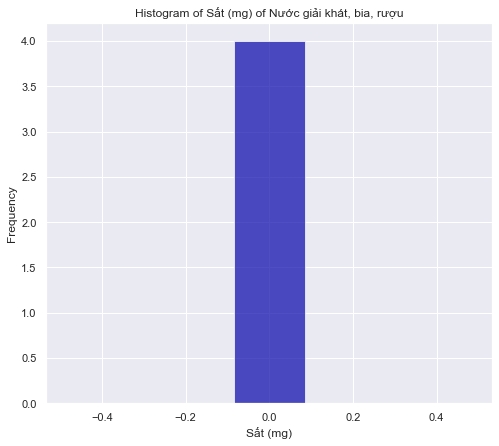

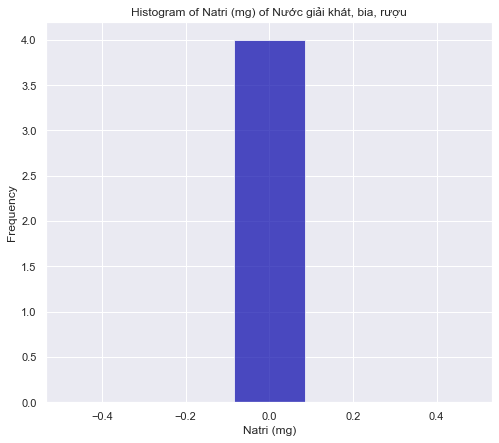

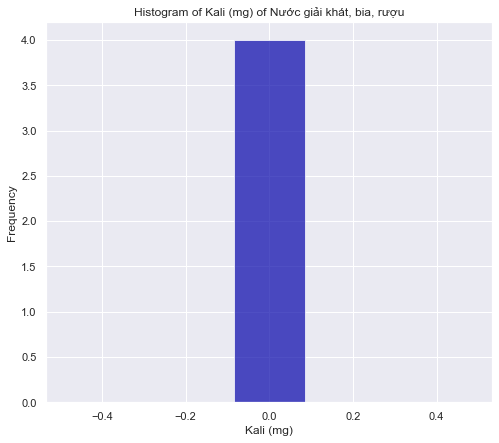

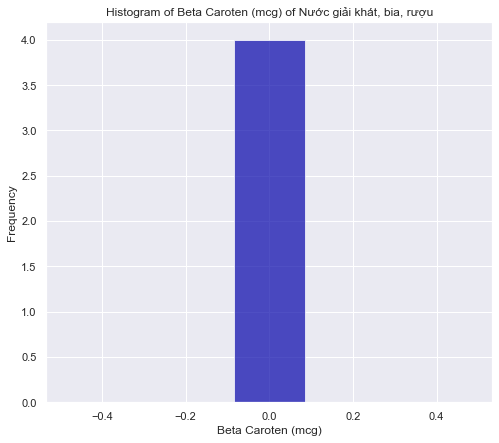

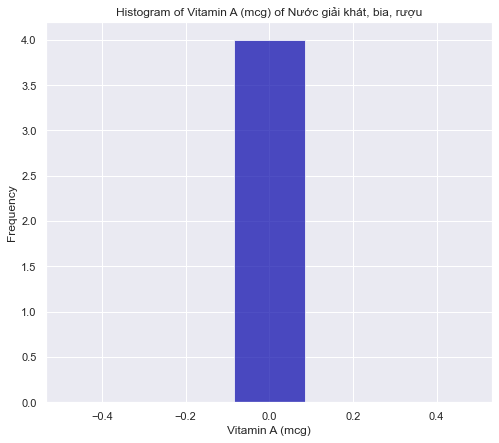

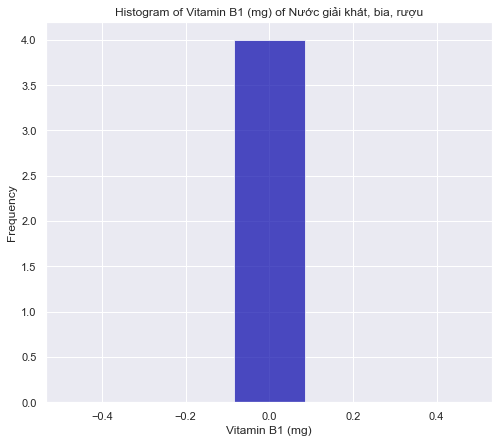

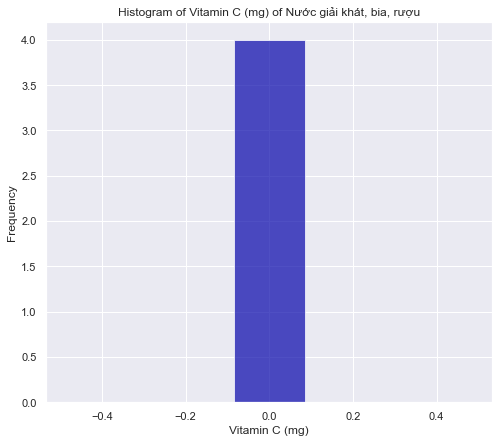

In [21]:
for i in food_type:
    for j in inspect_feature:
        arr = df.loc[df['Food Type'] == i]
        drawHistPlot(arr, 5, j, i)

- **Ngũ cốc và các sản phẩm chế biến từ chúng** có hàm lượng Calories, Fat và carbonhydrates cao nhưng lại gần như không chứa chất xơ (chỉ có 1 sản phẩm chứa 1 thành phần nhỏ) và hoàn toàn không chứa các loại vitamin hay khoáng chất 
- **Khoai củ và các sản phẩm chế biến từ chúng** có hàm lượng Calories gần như tương đương ngũ cốc, tuy nhiên lại chứa rất nhiều khoáng chất như canxi(tập trung ở khoảng 35g), sắt,vv và cũng hoàn toàn không chứa Vitamin
- **Các loại hạt quả** chứa tương đối ít calories và chỉ chứa vitamin C (không có vitamin A và B) tuy nhiên tương đối nhiều so với các loại thực phẩm khác (từ 0 đến 6mg)
-**Thịt và các sản phẩm chế biến** chứa lượng lớn Protein tập trung ở khoảng 20g (30/50 dòng dữ liệu ở khoảng này) và một số ít món có lượng protein >40g
-**Các loại vitamin** hầu như không xuất hiện trong nhiều thực phẩm, tuy nhiên các sản phẩm chế biến có nguồn gốc từ động vật chứa một lượng đáng kể vitamin A, nhưng nhìn chung sự phân bố của vitamin cũng ở gần mức 0mg
-**Trứng và các sản phẩm chế biến** hoàn toàn không có chất xơ tuy nhiên hầu hết các món ăn đều chứa lượng khoáng chất lớn

### So sánh các loại thực phẩm

In [22]:
type_df = df.groupby('Food Type').median()
columns = type_df.columns

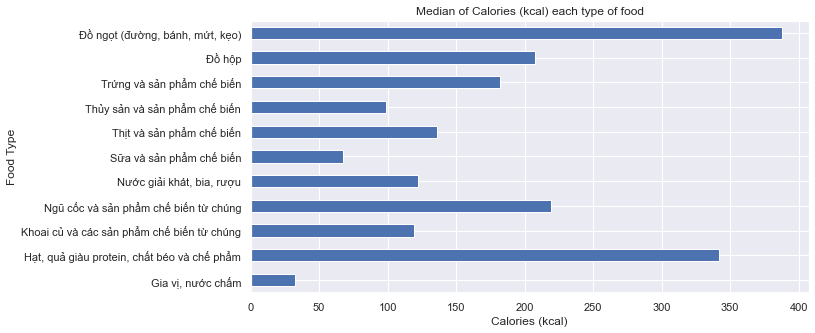

In [23]:
type_df.iloc[:,0].plot.barh(figsize=(10,5))
plt.xlabel(columns[0])
plt.title('Median of ' + columns[0] + ' each type of food')
plt.show()

### So sánh một số thực phẩm quen thuộc

Các thực phẩm quen thuộc do nhóm tự chọn

In [24]:
common_food = ['Bánh mì', 'Gạo tẻ', 'Bún', 'Đậu phụ', 'Thịt bò', 'Thịt gà ta', 'Thịt heo ba chỉ', 'Chả lụa', 'Xúc xích', 'Cá ngừ', 'Cá rô phi', 'Cá thu', 'Tôm biển', 'Trứng gà', 'Sữa bò tươi', 'Đường cát trắng', 'Muối', 'Nước mắm', 'Xì dầu', 'Bia']

In [25]:
cfood_df = pd.DataFrame(columns = df.columns.copy())
for cfood in common_food:
    cfood_df = cfood_df.append(df[df['Food Name'] == cfood].copy())

In [26]:
cfood_df.shape

(20, 17)

In [27]:
cfood_col = cfood_df.select_dtypes(include= 'object').columns.copy()
cfood_col = np.delete(cfood_col,[0,6])
cfood_col
for col in cfood_col:
    cfood_df[col] = cfood_df[col].astype(float)


In [28]:
def draw_bar (data_frame, renderTo, title_name, subtitle, typeData = 'default', header_tooltip = 'header'):
  data_frame_visualization = serialize(data_frame, render_to=renderTo, output_type="dict")
  data_frame_visualization["title"] = {"text" : {title_name}}
  data_frame_visualization["subtitle"] = {"text": f"{subtitle}"}
  data_frame_visualization["chart"]["type"] = "column"
  data_frame_visualization["xAxis"]["type"] = "category"

  if (typeData == 'default'):
    data_frame_visualization["plotOptions"] = {"series": {"borderWidth": 0,"dataLabels": {"enabled": "true"}}}
    data_frame_visualization["tooltip"] = {
        "headerFormat": '<span style="font-size:11px"><b>{header}</b></span><br>'.format(header=header_tooltip), 
        "pointFormat": '<span style="color:{point.color}">{point.name}</span>: <b>{point.y}</b><br/>'}
  else:
    if (typeData == 'rate'):
      data_frame_visualization["plotOptions"] = {"series": 
                                                 {"borderWidth": 0,"dataLabels": 
                                                  {"enabled": "true", "format": '{point.y:.2f}%'}}}
      data_frame_visualization["tooltip"] = {
          "headerFormat": '<span style="font-size:11px"><b>{header}</b></span><br>'.format(header=header_tooltip),
          "pointFormat": '<span style="color:{point.color}">{point.name}</span>: <b>{point.y:.2f}%</b> of total<br/>'}
    else:
      data_frame_visualization["plotOptions"] = {"series": 
                                                 {"borderWidth": 0,"dataLabels": 
                                                  {"enabled": "true", "format": '{point.y:.2f}'}}}
      data_frame_visualization["tooltip"] = {
        "headerFormat": '<span style="font-size:11px"><b>{header}</b></span><br>'.format(header=header_tooltip), 
        "pointFormat": '<span style="color:{point.color}">{point.name}</span>: <b>{point.y:.2f}</b><br/>'}

  json_data_frame= "new Highcharts.Chart(%s);" % json_encode(data_frame_visualization)

  display(HTML(
    """
    <meta charset="utf-8"> 
    <div id="{chart_id}"</div>
    <script src="//code.highcharts.com/stock/highstock.js"></script><script src="//code.highcharts.com/highcharts-more.js"></script>
    <script src="//code.highcharts.com/modules/exporting.js"></script><script type="text/javascript">{data}</script>        
    """.format(chart_id=renderTo, data=json_data_frame)))

In [29]:
for column in cfood_df.select_dtypes(exclude='object').columns:
    cfood_df_ = cfood_df[['Food Name',f'{column}']].copy()
    cfood_df_ = cfood_df_.sort_values(by = [f'{column}'], ascending=True)
    cfood_df_ = cfood_df_.set_index('Food Name')
    draw_bar(cfood_df_,
            header_tooltip=f'{column}',
            renderTo=f'cfood_{column}', 
            title_name=f'Distribution of {column}',
            subtitle='of common food')

- Chỉ có một số thực phẩm chứa các chất khoáng
- Xúc xích nhiều kcal nhất nhờ đứng đầu ở fat và protein
- Trứng gà có rất nhiều cholesterol (600mg), ngoài ra, trong danh sách này chỉ có sữa bò tươi và thịt bò có cholesterol ở hàm lượng thấp hơn rất nhiều: sữa bò tươi 30mg và thịt bò 59mg
-Trứng gà chứa đến 700mcg Vitamin A, gấp 5.834 lần thịt gà ta đứng thứ hai với 120mcg

...

### Mô hình tuyến tính

In [30]:
df.columns

Index(['Food Name', 'Calories (kcal)', 'Protein (g)', 'Fat (g)',
       'Carbonhydrates (g)', 'Chất xơ (g)', 'Cholesterol (mg)', 'Canxi (mg)',
       'Photpho (mg)', 'Sắt (mg)', 'Natri (mg)', 'Kali (mg)',
       'Beta Caroten (mcg)', 'Vitamin A (mcg)', 'Vitamin B1 (mg)',
       'Vitamin C (mg)', 'Food Type'],
      dtype='object')

In [31]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

y = df[['Calories (kcal)']]
model_df = df.drop(columns=['Food Name', 'Food Type', 'Calories (kcal)'])
results = sm.OLS(y, sm.add_constant(model_df)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:        Calories (kcal)   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     563.8
Date:                Sun, 18 Jul 2021   Prob (F-statistic):          6.60e-119
Time:                        17:52:09   Log-Likelihood:                -726.21
No. Observations:                 162   AIC:                             1480.
Df Residuals:                     148   BIC:                             1524.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 14.5964      3

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars
  return np.sqrt(eigvals[0]/eigvals[-1])


- Có thể thấy "Protein", "Fat", "Carbohydrates" là các biến độc lập có mối quan hệ tương quan với biến phụ thuộc "Calories"  (vì p_value < 0.05) và có ý nghĩa về mặt thống kê. Trong khi các biến còn lại không có ý nghĩa về mặt thống kê vì vậy có thể loại bỏ các biến này khỏi mô hình
- Có thể thấy một điều đáng chú ý là R-squared = 0.980 điều này có nghĩa là biến độc lập "Calories" hoàn toàn có thể giải thích được thông qua các biến vừa rồi